<a href="https://colab.research.google.com/github/nicolas-garc/STATGR5243_Project1_FrogTail/blob/main/Final_Frog_and_Tail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can frogs grow its tail back?


In [ ]:
!pip install scanpy anndata scvi-tools leidenalg bbknn harmonypy magic-impute tabulate openpyxl igraph --quiet
import os
import re
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.9/628.9 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25

## Data accession

Load data from the link directly or load it through Courseworks .zip file.

In [ ]:
!wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip -O /content/frogtail.zip

--2025-11-11 01:30:38--  https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94419121 (90M) [application/zip]
Saving to: ‘/content/frogtail.zip’

/content/frogtail.z 100%[===================>]  90.04M   175MB/s    in 0.5s    

2025-11-11 01:30:39 (175 MB/s) - ‘/content/frogtail.zip’ saved [94419121/94419121]



In [ ]:
import zipfile
import os

zip_file = "/content/frogtail.zip" # replace path to your zip file's path
extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/" # where zip file is going to be extracted to

os.makedirs(extract_dir, exist_ok=True) # create the extraction directory if it doesn't exist

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/TA/Frogtail_files/


In [ ]:
zip_file = extract_dir+"ArrayExpressV2.zip" # file is a nested zip, dezip again

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/TA/Frogtail_files/


In [ ]:
TABLE_S3_PATH = "/content/drive/MyDrive/aav9996_tables3.xlsx"

## Make an anndata matrix using scanpy or anndata

Usually single cell data is either directly stored in highdimensional files with .h5 extensions or in compressed count matrices with several tsv/csv/json logging the covariates information. Here is an example of how to compress and download this data into an anndata object that facilitates downstream single cell analysis.

- AnnData object for single cell data:  [Documentation](https://https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)
- Scanpy for single cell analysis: [Documentation](https://scanpy.readthedocs.io/en/stable/index.html)



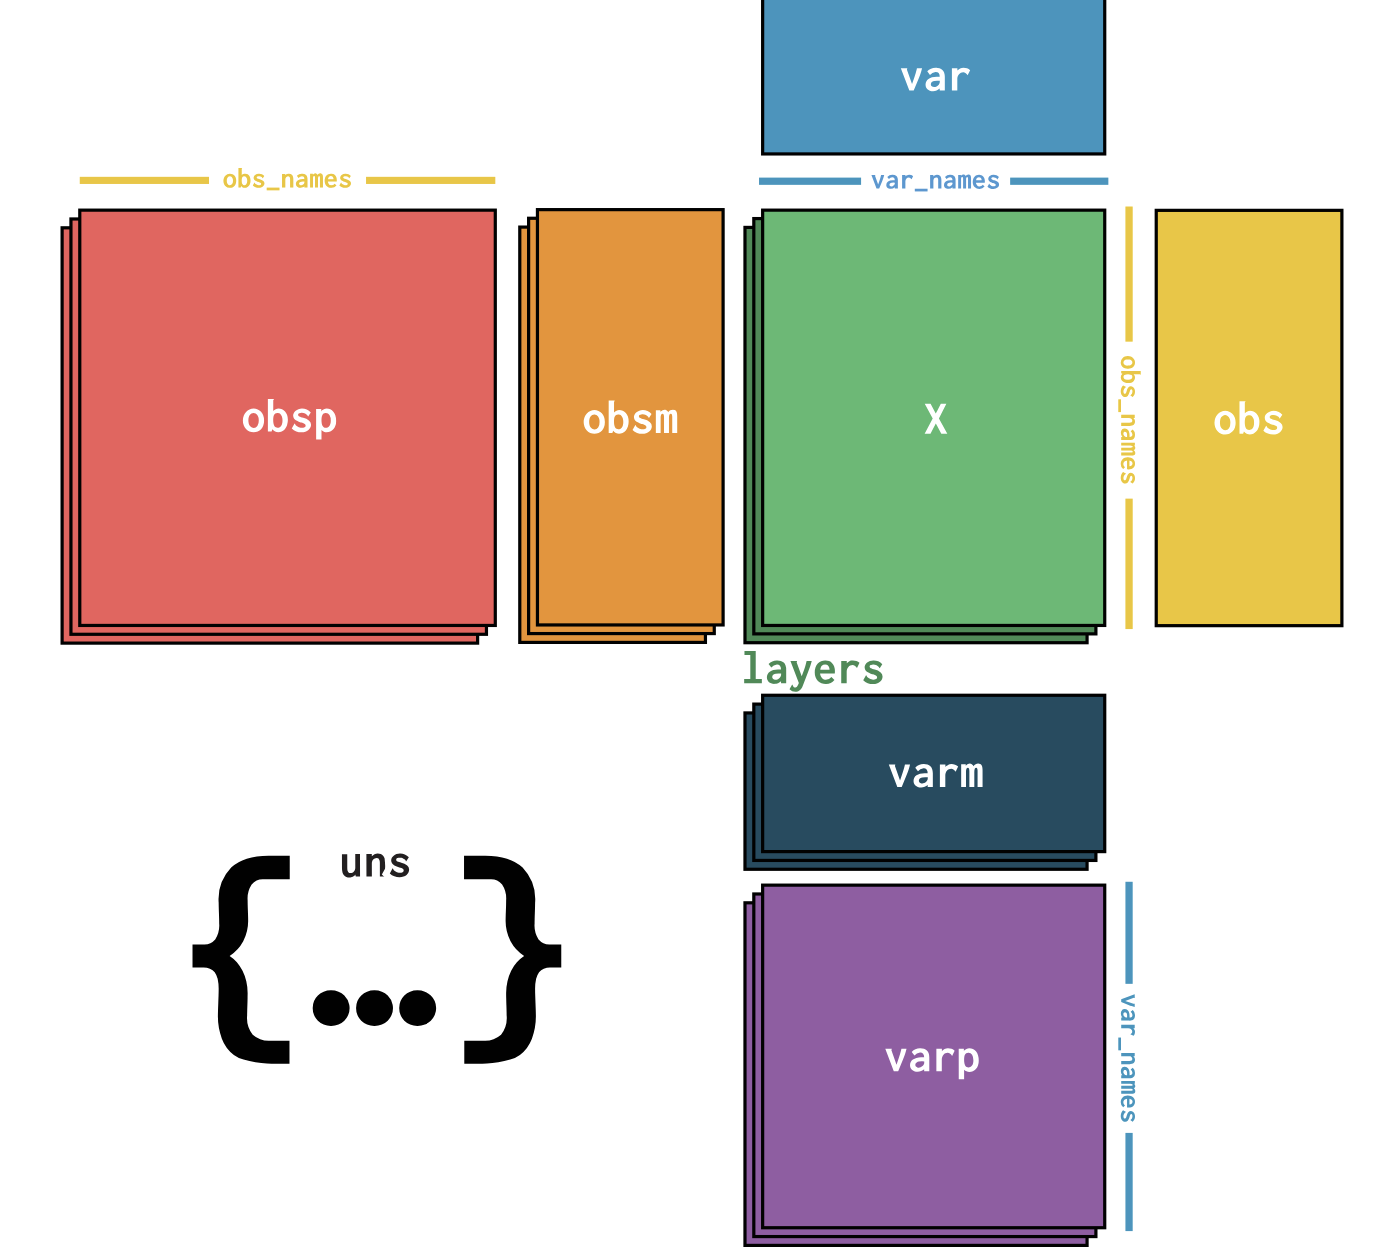

In [ ]:
X = mmread(extract_dir+'ArrayExpress/countsMatrix.mtx') # compressed sparse matrix of gene expression
X = X.tocsr() # convert to sparse matrix
genes = pd.read_csv(extract_dir+'ArrayExpress/genes.csv', sep=' ', header=None) # col names of genes
cells = pd.read_csv(extract_dir+'ArrayExpress/cells.csv', sep=' ', header=None) # row names of cells
labels = pd.read_csv(extract_dir+'ArrayExpress/labels.csv')
meta = pd.read_csv(extract_dir+'ArrayExpress/meta.csv')


adata = ad.AnnData(X.T)

In [ ]:
cells.columns = ['barcode_cells']
meta_aug = pd.merge(meta, labels, left_on='sample', right_on='Sample', how='left')

In [ ]:
adata.var_names = genes[0]
adata.obs = pd.merge(cells, meta_aug, left_on='barcode_cells', right_on='cell')


In [ ]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [ ]:
adata.var

Empty DataFrame
Columns: []
Index: [Xelaev18000001m.g, Xelaev18000003m.g, Xelaev18000004m.g, Xelaev18000005m.g, tm6sf2.1, Xelaev18000007m.g, bpi.S, Xelaev18000010m.g, Xelaev18000011m.g, Xelaev18000015m.g, arhgap28.S, tmem200c.S, Xelaev18000024m.g, Xelaev18000025m.g, Xelaev18000026m.g, bcap31.L, Xelaev18000028m.g, plxnb3.L, loc100493711.L, wnt7c.L, hsd17b10.L, syp.L, gpkow.L, plp2.L, prickle3.like.L, klhl7.S, igf2bp3.S, Xelaev18000040m.g, Xelaev18000041m.g, tra2a.S, Xelaev18000045m.g, Xelaev18000047m.g, Xelaev18000048m.g, loc100491805.1.L, pga4.L, tmem132a.L, prpf19.L, Xelaev18000056m.g, Xelaev18000057m.g, hinfp.S, abcg4.S, pdzd3.S, cbl.S, mcam.S, Xelaev18000066m.g, Xelaev18000067m.g, Xelaev18000069m.g, Xelaev18000071m.g, Xelaev18000072m.g, loc443731, Xetrov90024636m.1, Xelaev18000089m.g, gkap1.L, mrps18c.1.L, loc100492437.L, MGC147600.1.L, Xelaev18000095m.g, Xelaev18000097m.g, Xelaev18000100m.g, taar1.L, Xelaev18000104m.g, Xelaev18000107m.g, Xelaev18000109m.g, Xelaev18000110m.g, srsf10.L, loc100145027.L, myom3.L, il22ra1.L, ifnlr1.L, Xelaev18000117m.g, Xelaev18000119m.g, gab1.L, smarca5.L, frem2.1.L, Xelaev18000125m.g, Xelaev18000127m.g, Xelaev18000128m.g, taf10, Xelaev18000132m.g, Xetrov90002011m.L, ppp1r3b.L, Xelaev18000135m.g, eri1.L, ubap2.L, dcaf12.L, ube2r2.L, loc101733340.1.L, Xelaev18000150m.g, Xelaev18000152m.g, loc101734519.1.L, Xelaev18000156m.g, Xelaev18000158m.g, Xelaev18000159m.g, Xelaev18000160m.g, Xelaev18000166m.g, Xelaev18000173m.g, irx5.1.L, Xelaev18000175m.g, Xetrov90000066m.1, cep295.S, ...]

[31535 rows x 0 columns]

In [ ]:
adata.X = adata.X.tocsr()

In [ ]:
adata.write_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad')

## Load data

In [ ]:
import anndata as ad
extract_dir = "/content/drive/MyDrive/TA"
adata = ad.read_h5ad('/content/drive/MyDrive/TA/Frogtail_files/cleaned_processed_frogtail.h5ad') # ad.read_h5ad()

In [ ]:
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
adata.obs

barcode_cells                  cell   sample DevelopmentalStage  \
0        AAACCTGAGCTAGTTC.1    AAACCTGAGCTAGTTC.1   SIGAB5               st40   
1        AAACCTGGTGGGTCAA.1    AAACCTGGTGGGTCAA.1   SIGAB5               st40   
2        AAACCTGGTTTGTTGG.1    AAACCTGGTTTGTTGG.1   SIGAB5               st40   
3        AAACGGGGTCGGCATC.1    AAACGGGGTCGGCATC.1   SIGAB5               st40   
4        AAACGGGTCCTACAGA.1    AAACGGGTCCTACAGA.1   SIGAB5               st40   
...                     ...                   ...      ...                ...   
13194    TTCTTAGAGTACCGGA.1    TTCTTAGAGTACCGGA.1  SIGAB10               st40   
13195    TTGACTTAGAGTAAGG.1    TTGACTTAGAGTAAGG.1  SIGAB10               st40   
13196    TTGCGTCTCAAGAAGT.1    TTGCGTCTCAAGAAGT.1  SIGAB10               st40   
13197    TTGTAGGCAGTACACT.1    TTGTAGGCAGTACACT.1  SIGAB10               st40   
13198  TTTGCGCAGCGTGAAC.1.1  TTTGCGCAGCGTGAAC.1.1  SIGAB10               st40   

       DaysPostAmputation        cluster         X          Y CellCyclePhase  \
0                       3  Erythrocyte 4 -6.395430   0.832323            G2M   
1                       3      Myeloid 1 -2.428271  13.826715             G1   
2                       3  Beta ionocyte -1.398049 -14.653897             G1   
3                       3  Erythrocyte 4 -5.863765   0.489598            G2M   
4                       3    Goblet cell  2.106444  -6.594430             G1   
...                   ...            ...       ...        ...            ...   
13194                   3  Erythrocyte 4 -5.879582   0.924197            G2M   
13195                   3    Goblet cell  1.252149  -8.870151             G1   
13196                   3    Goblet cell  0.693335  -9.168521             G1   
13197                   3  Erythrocyte 1 -4.087618   4.145738             G1   
13198                   3    Goblet cell  0.803595  -7.395422             G1   

        Sample       Lane Condition  batch  
0       SIGAB5  SLX-15583    ST40_3      3  
1       SIGAB5  SLX-15583    ST40_3      3  
2       SIGAB5  SLX-15583    ST40_3      3  
3       SIGAB5  SLX-15583    ST40_3      3  
4       SIGAB5  SLX-15583    ST40_3      3  
...        ...        ...       ...    ...  
13194  SIGAB10  SLX-15739    ST40_3      4  
13195  SIGAB10  SLX-15739    ST40_3      4  
13196  SIGAB10  SLX-15739    ST40_3      4  
13197  SIGAB10  SLX-15739    ST40_3      4  
13198  SIGAB10  SLX-15739    ST40_3      4  

[13199 rows x 13 columns]

In [ ]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [ ]:
adata.obs

barcode_cells                  cell   sample DevelopmentalStage  \
0        AAACCTGAGCTAGTTC.1    AAACCTGAGCTAGTTC.1   SIGAB5               st40   
1        AAACCTGGTGGGTCAA.1    AAACCTGGTGGGTCAA.1   SIGAB5               st40   
2        AAACCTGGTTTGTTGG.1    AAACCTGGTTTGTTGG.1   SIGAB5               st40   
3        AAACGGGGTCGGCATC.1    AAACGGGGTCGGCATC.1   SIGAB5               st40   
4        AAACGGGTCCTACAGA.1    AAACGGGTCCTACAGA.1   SIGAB5               st40   
...                     ...                   ...      ...                ...   
13194    TTCTTAGAGTACCGGA.1    TTCTTAGAGTACCGGA.1  SIGAB10               st40   
13195    TTGACTTAGAGTAAGG.1    TTGACTTAGAGTAAGG.1  SIGAB10               st40   
13196    TTGCGTCTCAAGAAGT.1    TTGCGTCTCAAGAAGT.1  SIGAB10               st40   
13197    TTGTAGGCAGTACACT.1    TTGTAGGCAGTACACT.1  SIGAB10               st40   
13198  TTTGCGCAGCGTGAAC.1.1  TTTGCGCAGCGTGAAC.1.1  SIGAB10               st40   

       DaysPostAmputation        cluster         X          Y CellCyclePhase  \
0                       3  Erythrocyte 4 -6.395430   0.832323            G2M   
1                       3      Myeloid 1 -2.428271  13.826715             G1   
2                       3  Beta ionocyte -1.398049 -14.653897             G1   
3                       3  Erythrocyte 4 -5.863765   0.489598            G2M   
4                       3    Goblet cell  2.106444  -6.594430             G1   
...                   ...            ...       ...        ...            ...   
13194                   3  Erythrocyte 4 -5.879582   0.924197            G2M   
13195                   3    Goblet cell  1.252149  -8.870151             G1   
13196                   3    Goblet cell  0.693335  -9.168521             G1   
13197                   3  Erythrocyte 1 -4.087618   4.145738             G1   
13198                   3    Goblet cell  0.803595  -7.395422             G1   

        Sample       Lane Condition  batch  
0       SIGAB5  SLX-15583    ST40_3      3  
1       SIGAB5  SLX-15583    ST40_3      3  
2       SIGAB5  SLX-15583    ST40_3      3  
3       SIGAB5  SLX-15583    ST40_3      3  
4       SIGAB5  SLX-15583    ST40_3      3  
...        ...        ...       ...    ...  
13194  SIGAB10  SLX-15739    ST40_3      4  
13195  SIGAB10  SLX-15739    ST40_3      4  
13196  SIGAB10  SLX-15739    ST40_3      4  
13197  SIGAB10  SLX-15739    ST40_3      4  
13198  SIGAB10  SLX-15739    ST40_3      4  

[13199 rows x 13 columns]

## Processing data

In [ ]:
adata.layers["counts"] = adata.X.copy()


In [ ]:
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)

In [ ]:
hvg = adata.var["highly_variable"].to_numpy()
adata.obsm["X_log2_hvg"] = adata[:, hvg].X


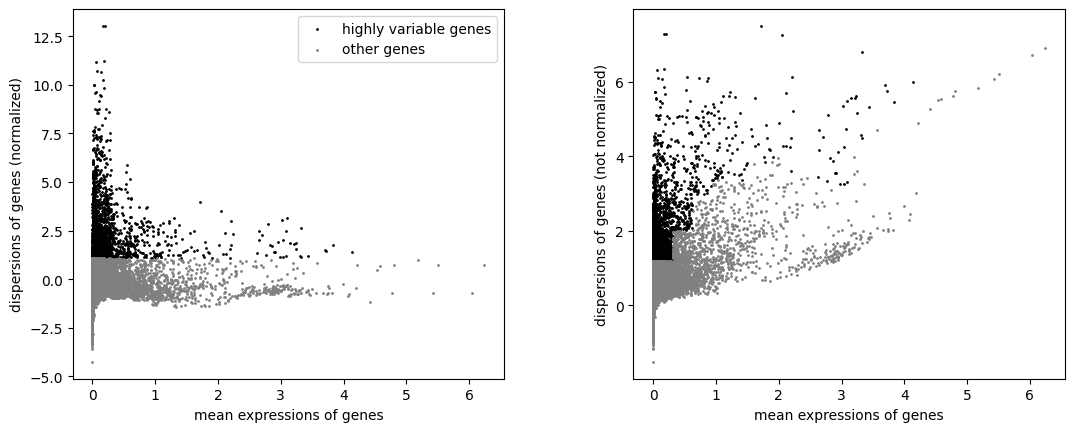

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

print(adata)

# PCA on HVGs only
hvg_mask = adata.var["highly_variable"].values
adata_hvg = adata[:, hvg_mask].copy()

sc.pp.scale(adata_hvg, zero_center=True, max_value=10)
sc.tl.pca(adata_hvg, n_comps=50, svd_solver="arpack")

adata.obsm["X_pca"] = adata_hvg.obsm["X_pca"].copy()


AnnData object with n_obs × n_vars = 13199 × 26166
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_log2_hvg'
    layers: 'counts'


In [ ]:

# Neighbors + UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)


In [ ]:
#sc.tl.louvain(adata, key_added="louvain")

In [ ]:
sc.tl.leiden(adata, key_added="leiden")


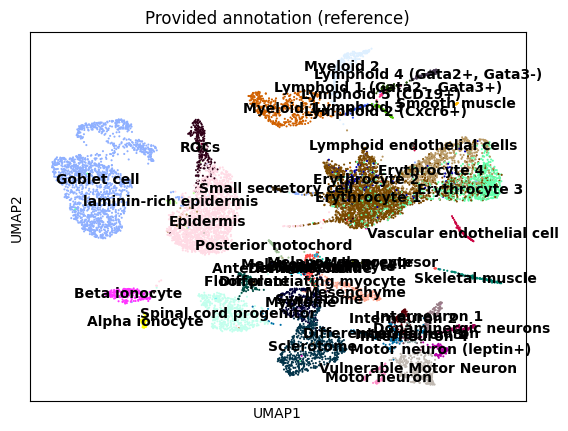

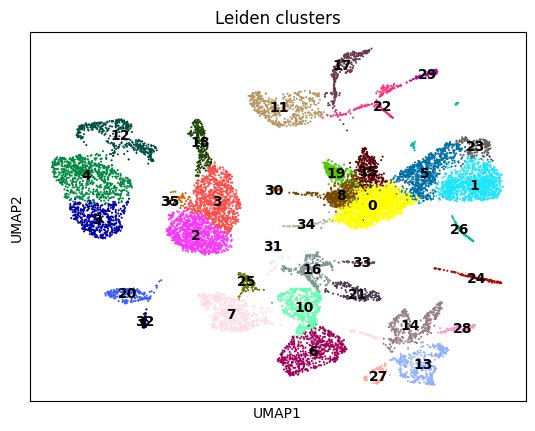

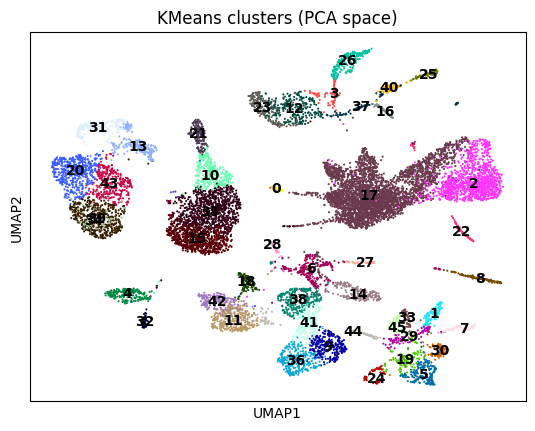

method  n_clusters       ARI  RandIndex  Silhouette_PCA  \
0  leiden          36  0.484483   0.926450        0.241852   
1  kmeans          46  0.526036   0.914686        0.349193   

   CalinskiHarabasz_PCA  DaviesBouldin_PCA  
0           1532.947266           1.318344  
1           1972.115601           1.152038

In [ ]:
# -------------------------
# Leiden (graph-based clustering)
# -------------------------
sc.tl.leiden(adata, key_added="leiden")

# -------------------------
# KMeans on PCA space
# -------------------------
if "cluster" in adata.obs:
    n_true = int(adata.obs["cluster"].nunique())
else:
    n_true = 10

X_pca = adata.obsm["X_pca"]
kmeans = KMeans(n_clusters=n_true, random_state=0, n_init=10)
adata.obs["kmeans"] = kmeans.fit_predict(X_pca).astype(str)

# -------------------------
# UMAP visualizations
# -------------------------
sc.pl.umap(
    adata,
    color=["cluster"],
    title="Provided annotation (reference)",
    legend_loc="on data",
    wspace=0.4,
)
sc.pl.umap(
    adata,
    color=["leiden"],
    title="Leiden clusters",
    legend_loc="on data",
    wspace=0.4,
)
sc.pl.umap(
    adata,
    color=["kmeans"],
    title="KMeans clusters (PCA space)",
    legend_loc="on data",
    wspace=0.4,
)

# -------------------------
# Metrics vs reference labels
# -------------------------
if "cluster" in adata.obs:
    y_true = adata.obs["cluster"].astype("category")

    methods = []
    if "leiden" in adata.obs:
        methods.append("leiden")
    if "kmeans" in adata.obs:
        methods.append("kmeans")

    rows = []
    for key in methods:
        y_pred = adata.obs[key].astype("category")
        labs = y_pred.cat.codes.values

        if y_pred.nunique() > 1:
            ari = adjusted_rand_score(y_true, y_pred)
            ri = rand_score(y_true, y_pred)
            sil = silhouette_score(X_pca, labs)
            ch = calinski_harabasz_score(X_pca, labs)
            db = davies_bouldin_score(X_pca, labs)
        else:
            ari = ri = sil = ch = db = np.nan

        rows.append(
            dict(
                method=key,
                n_clusters=y_pred.nunique(),
                ARI=ari,
                RandIndex=ri,
                Silhouette_PCA=sil,
                CalinskiHarabasz_PCA=ch,
                DaviesBouldin_PCA=db,
            )
        )

    display(pd.DataFrame(rows))
else:
    print("No 'cluster' column found in adata.obs to use as reference labels.")


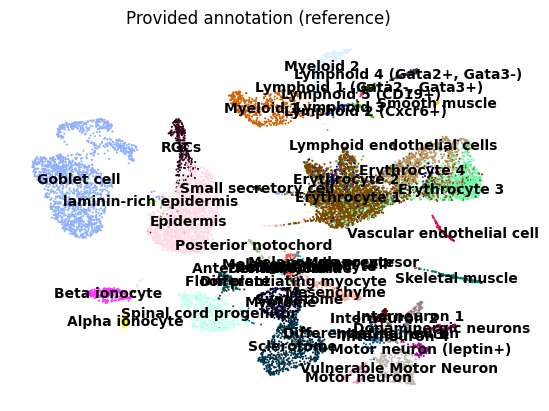

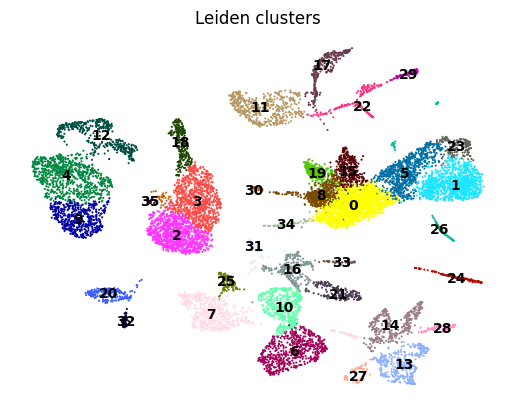

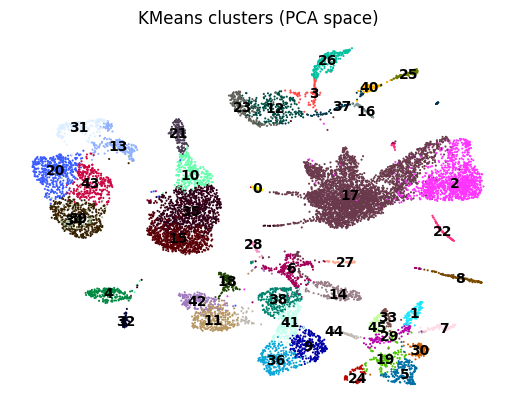

UMAP figures saved under /content/figures (Scanpy may put them in ./figures/).


In [ ]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# ------------------------------------------------------------------
# 1. Make sure output dir for figures exists
# ------------------------------------------------------------------
fig_dir = "./figures"
os.makedirs(fig_dir, exist_ok=True)

# ------------------------------------------------------------------
# 2. UMAP plots: reference + each clustering method
#    (Louvain removed; we only use Leiden + KMeans)
# ------------------------------------------------------------------
plot_keys = {
    "cluster": "Provided annotation (reference)",
    "leiden": "Leiden clusters",
    "kmeans": "KMeans clusters (PCA space)",
}

for key, title in plot_keys.items():
    if key in adata.obs:
        sc.pl.umap(
            adata,
            color=key,
            title=title,
            legend_loc="on data",
            frameon=False,
            wspace=0.4,
            show=True,
            save=f"_{key}.png",  # Scanpy will save into ./figures as umap_{key}.png
        )

print(f"UMAP figures saved under {os.path.abspath('./figures')} "
      "(Scanpy may put them in ./figures/).")

# ------------------------------------------------------------------
# 3. Metrics table vs ground truth labels
#    (Evaluated for Leiden + KMeans only)
# ------------------------------------------------------------------
if "cluster" in adata.obs:
    if "X_pca" not in adata.obsm:
        raise ValueError("X_pca not found in adata.obsm. Run PCA before this cell.")

    y_true = adata.obs["cluster"].astype("category")
    X_pca = adata.obsm["X_pca"]

    results = []
    for key in ["leiden", "kmeans"]:
        if key not in adata.obs:
            continue

        y_pred = adata.obs[key].astype("category")
        n_clust = y_pred.nunique()
        labels_numeric = y_pred.cat.codes.values

        if n_clust > 1:
            ari = adjusted_rand_score(y_true, y_pred)
            ri = rand_score(y_true, y_pred)
            sil = silhouette_score(X_pca, labels_numeric)
            ch = calinski_harabasz_score(X_pca, labels_numeric)
            db = davies_bouldin_score(X_pca, labels_numeric)
        else:
            ari = ri = sil = ch = db = np.nan

        results.append(
            {
                "method": key,
                "n_clusters": n_clust,
                "ARI_vs_ref": ari,
                "RandIndex_vs_ref": ri,
                "Silhouette_on_PCA": sil,
                "CalinskiHarabasz_on_PCA": ch,
                "DaviesBouldin_on_PCA": db,
            }
        )

    metrics_df = pd.DataFrame(results).set_index("method")
    display(
        metrics_df.style.format(
            {
                "ARI_vs_ref": "{:.3f}",
                "RandIndex_vs_ref": "{:.3f}",
                "Silhouette_on_PCA": "{:.3f}",
                "CalinskiHarabasz_on_PCA": "{:.1f}",
                "DaviesBouldin_on_PCA": "{:.3f}",
            }
        )
    )
else:
    print("No 'cluster' column in adata.obs; cannot compute metrics vs reference.")


# Marker Selection

In [ ]:

# Ensure 'cluster' is categorical
if 'cluster' not in adata.obs:
    raise ValueError("No 'cluster' column in adata.obs; cannot define ROC group.")

adata.obs['cluster'] = adata.obs['cluster'].astype('category')
print("Available clusters:\n", adata.obs['cluster'].cat.categories)

# 1. Select ROC cluster label explicitly
if "ROCs" not in adata.obs['cluster'].cat.categories:
    raise ValueError("Expected 'ROCs' in cluster labels; please check adata.obs['cluster'].")

roc_label = "ROCs"
print(f"Using ROC cluster label: {roc_label}")

# 2. Marker selection: Wilcoxon (ROC vs rest)
sc.tl.rank_genes_groups(
    adata,
    groupby='cluster',
    groups=[roc_label],
    reference='rest',
    method='wilcoxon',
    use_raw=True,
    key_added='markers_wilcoxon'
)

# 3. Marker selection: Logistic Regression on ALL clusters
#    (we will later extract ROC-specific markers)
sc.tl.rank_genes_groups(
    adata,
    groupby='cluster',
    method='logreg',
    use_raw=True,
    key_added='markers_logreg_all'
)

# 4. Helper: convert rank_genes_groups output -> DataFrame
def get_marker_df(adata, key, group, n_top=200):
    rg = adata.uns[key]
    names = rg['names'][group][:n_top]
    scores = rg['scores'][group][:n_top]

    if 'pvals_adj' in rg:
        pvals = rg['pvals_adj'][group][:n_top]
    else:
        pvals = rg['pvals'][group][:n_top] if 'pvals' in rg else np.full(len(names), np.nan)

    if 'logfoldchanges' in rg:
        logfc = rg['logfoldchanges'][group][:n_top]
    else:
        logfc = np.full(len(names), np.nan)

    return pd.DataFrame({
        'gene': names,
        'score': scores,
        'logFC': logfc,
        'pval_adj': pvals
    })

# ROC markers from both methods
roc_wilcoxon = get_marker_df(adata, 'markers_wilcoxon', roc_label, n_top=200)
roc_logreg   = get_marker_df(adata, 'markers_logreg_all', roc_label, n_top=200)

# Overlap between methods
overlap = pd.merge(
    roc_wilcoxon,
    roc_logreg,
    on='gene',
    suffixes=('_wilcoxon', '_logreg')
)

print("\nTop 10 ROC markers by Wilcoxon:")
display(roc_wilcoxon.head(10))

print("\nTop 10 ROC markers by Logistic Regression:")
display(roc_logreg.head(10))

print("\nOverlap between Wilcoxon + LogReg (top 20 by Wilcoxon score):")
display(overlap.sort_values('score_wilcoxon', ascending=False).head(20))

# 5. Compare with Supplementary Table 3 gene set
TABLE_S3_PATH = "/content/drive/MyDrive/aav9996_tables3.xlsx"

try:
    s3 = pd.read_excel(TABLE_S3_PATH, sheet_name=0)
except Exception as e:
    print("\nCould not read Supplementary Table 3 file:", e)
    s3 = None

import re
import pandas as pd

# ---------- 1. Canonicalization helper ----------
def canon(g):
    """
    Normalize gene names:
    - strip whitespace
    - remove trailing .L / .S (Xenopus isoforms)
    - drop non-alphanumeric chars
    - uppercase
    """
    g = str(g).strip()
    g = re.sub(r'\.(L|S)$', '', g)      # remove only suffix .L or .S
    g = re.sub(r'[^A-Za-z0-9]', '', g)  # remove anything weird
    return g.upper()

# ---------- 2. Table 3 gene list (from file OR manual) ----------

# (a) Try from Excel if loaded earlier
table3_genes = []

if s3 is not None:
    # assume single gene column or first column is gene names
    gene_col = s3.columns[0]
    table3_genes = (
        s3[gene_col]
        .dropna()
        .astype(str)
        .tolist()
    )

# (b) Manual override using the list you pasted (this guarantees correctness)
manual_table3 = [
    "wnt5a",
    "loc100488523",
    "loc100492954",
    "egfl6",
    "lpar3",
    "cpa6",
    "sp9",
    "fgf9",
    "fbn2",
    "tinagl1",
    "fgf7",
    "vwde",
    "lef1",
    "lamb2",
    "fgfr4",
    "fgf7",
    "rspo2",
    "cpa6",
    "loc100498358",
    "krt",
    "loc100486832",
    "jag1",
    "Xelaev18043128m",
    "dlx2",
    "tp73",
    "gdf6",
    "Xelaev18046800m",
    "nid2",
    "igfbp2",
    "ism2",
    "dlx2",
    "loc100493805",
    "frem2",
    "Xelaev18044182m",
    "bmp5",
    "tspear",
    "sema3f",
    "robo4",
    "jchain",
    "rspo2",
    "adamts18",
    "pltp",
    "Xelaev18034799m",
    "lamb1",
    "lamb1",
    "unc5b",
    "mmp28",
    "fgf10",
    "pzp",
    "galnt15",
]

# if manual list is present, use it as ground truth
if manual_table3:
    table3_genes = manual_table3

# canonical set
table3_genes_c = {canon(g) for g in table3_genes if g}

print(f"Loaded {len(table3_genes)} raw Table 3 entries, {len(table3_genes_c)} unique canonical IDs.")

# ---------- 3. Canonicalize ROC markers ----------
roc_wilcoxon_c = roc_wilcoxon.copy()
roc_logreg_c   = roc_logreg.copy()
overlap_c      = overlap.copy()

roc_wilcoxon_c["gene_c"] = roc_wilcoxon_c["gene"].map(canon)
roc_logreg_c["gene_c"]   = roc_logreg_c["gene"].map(canon)
overlap_c["gene_c"]      = overlap_c["gene"].map(canon)

# ---------- 4. Compute overlaps ----------
wilcoxon_in_s3_c = roc_wilcoxon_c[roc_wilcoxon_c["gene_c"].isin(table3_genes_c)]
logreg_in_s3_c   = roc_logreg_c[roc_logreg_c["gene_c"].isin(table3_genes_c)]
overlap_in_both_c = overlap_c[overlap_c["gene_c"].isin(table3_genes_c)]

print("\nCanonical overlap counts:")
print(f" Wilcoxon ROC markers overlapping Table 3: {len(wilcoxon_in_s3_c)}")
print(f" LogReg ROC markers overlapping Table 3: {len(logreg_in_s3_c)}")
print(f" High-confidence (in both methods + Table 3): {len(overlap_in_both_c)}")

print("\nExamples: Wilcoxon ROC markers overlapping Table 3 (canonical):")
display(wilcoxon_in_s3_c.head(20))

print("\nExamples: LogReg ROC markers overlapping Table 3 (canonical):")
display(logreg_in_s3_c.head(20))

print("\nExamples: high-confidence ROC markers (both methods + Table 3, canonical):")
display(overlap_in_both_c.head(20))


Available clusters:
 Index(['Alpha ionocyte', 'Anterior notochord', 'Beta ionocyte', 'Dermomyotome',
       'Differentiating myocyte', 'Differentiating neuron',
       'Dopaminergic neurons', 'Epidermis', 'Erythrocyte 1', 'Erythrocyte 2',
       'Erythrocyte 3', 'Erythrocyte 4', 'Floor plate', 'Goblet cell',
       'Interneuron 1', 'Interneuron 2', 'Interneuron 3', 'Interneuron 4',
       'Lymphoid 1 (Gata2-, Gata3+)', 'Lymphoid 2 (Cxcr6+)', 'Lymphoid 3',
       'Lymphoid 4 (Gata2+, Gata3-)', 'Lymphoid 5 (CD19+)',
       'Lymphoid endothelial cells', 'Melanocyte', 'Melanocyte precursor',
       'Melanocyte stem cell', 'Mesenchyme', 'Motor neuron',
       'Motor neuron (leptin+)', 'Myeloid 1', 'Myeloid 2', 'Myotome',
       'Oligodendrocyte', 'Posterior notochord', 'ROCs', 'Satellite cell',
       'Sclerotome', 'Skeletal muscle', 'Small secretory cell',
       'Smooth muscle', 'Spinal cord progenitor', 'Syndetome',
       'Vascular endothelial cell', 'Vulnerable Motor Neuron',
       'l

gene      score     logFC       pval_adj
0       col14a1.S  25.357527  5.884367  2.340832e-137
1    apoc1.like.L  25.222475  8.242413  3.580654e-136
2  loc100486548.L  25.060778  5.087452  1.400259e-134
3           mdk.L  24.477623  4.950447  2.016198e-128
4           id3.S  23.945599  4.214293  6.476695e-123
5         lama5.L  23.924074  5.031434  9.042865e-123
6         fras1.L  23.778688  5.202516  2.500209e-121
7       col14a1.L  23.365553  4.591443  3.775154e-117
8           id3.L  23.067509  3.929649  3.439342e-114
9         bambi.L  22.982174  4.741649  2.216280e-113


Top 10 ROC markers by Logistic Regression:


gene     score  logFC  pval_adj
0       apoc1.like.L  0.486242    NaN       NaN
1             pltp.S  0.418675    NaN       NaN
2              fn1.S  0.329667    NaN       NaN
3              id3.L  0.296707    NaN       NaN
4  Xetrov90029035m.L  0.287145    NaN       NaN
5             nid2.L  0.278743    NaN       NaN
6          frem2.1.L  0.266963    NaN       NaN
7     loc100486548.L  0.259576    NaN       NaN
8            fstl1.L  0.247599    NaN       NaN
9           krt5.7.S  0.247056    NaN       NaN


Overlap between Wilcoxon + LogReg (top 20 by Wilcoxon score):


gene  score_wilcoxon  logFC_wilcoxon  pval_adj_wilcoxon  \
0        col14a1.S       25.357527        5.884367      2.340832e-137   
1     apoc1.like.L       25.222475        8.242413      3.580654e-136   
2   loc100486548.L       25.060778        5.087452      1.400259e-134   
3            mdk.L       24.477623        4.950447      2.016198e-128   
4            id3.S       23.945599        4.214293      6.476695e-123   
5          lama5.L       23.924074        5.031434      9.042865e-123   
6          fras1.L       23.778688        5.202516      2.500209e-121   
7        col14a1.L       23.365553        4.591443      3.775154e-117   
8            id3.L       23.067509        3.929649      3.439342e-114   
9          bambi.L       22.982174        4.741649      2.216280e-113   
10       frem2.1.L       22.910267        6.960566      1.052378e-112   
11         egfl6.S       22.220493        4.526450      5.719964e-106   
12           fn1.S       22.153709        5.105202      2.330573e-105   
13         azin2.S       21.984322        3.918051      9.164035e-104   
14          msx2.L       21.821768        4.165825      3.031132e-102   
15          plk2.S       21.574270        3.957284      6.176684e-100   
16          mmp3.L       21.240749        6.261422       7.033000e-97   
17        cpamd8.L       21.161226        4.118485       3.609805e-96   
18           mdk.S       21.039736        4.073524       4.477354e-95   
19         frem2.L       20.907410        4.130569       6.884357e-94   

    score_logreg  logFC_logreg  pval_adj_logreg  
0       0.240092           NaN              NaN  
1       0.486242           NaN              NaN  
2       0.259576           NaN              NaN  
3       0.227135           NaN              NaN  
4       0.209416           NaN              NaN  
5       0.217918           NaN              NaN  
6       0.215734           NaN              NaN  
7       0.226746           NaN              NaN  
8       0.296707           NaN              NaN  
9       0.172641           NaN              NaN  
10      0.266963           NaN              NaN  
11      0.113467           NaN              NaN  
12      0.329667           NaN              NaN  
13      0.201145           NaN              NaN  
14      0.111103           NaN              NaN  
15      0.183188           NaN              NaN  
16      0.143936           NaN              NaN  
17      0.163270           NaN              NaN  
18      0.191853           NaN              NaN  
19      0.095880           NaN              NaN


Could not read Supplementary Table 3 file: [Errno 2] No such file or directory: '/content/drive/MyDrive/aav9996_tables3.xlsx'
Loaded 50 raw Table 3 entries, 45 unique canonical IDs.

Canonical overlap counts:
 Wilcoxon ROC markers overlapping Table 3: 19
 LogReg ROC markers overlapping Table 3: 28
 High-confidence (in both methods + Table 3): 16

Examples: Wilcoxon ROC markers overlapping Table 3 (canonical):


gene      score     logFC       pval_adj   gene_c
11     egfl6.S  22.220493  4.526450  5.719964e-106    EGFL6
20     frem2.L  20.907410  4.130569   6.884357e-94    FREM2
22      nid2.L  20.682669  5.876601   6.803136e-92     NID2
35      pltp.S  19.899174  6.665701   3.623857e-85     PLTP
42    igfbp2.S  19.282396  4.411822   5.536647e-80   IGFBP2
66     egfl6.L  17.556669  5.801909   2.489368e-66    EGFL6
81     lpar3.L  17.052761  6.247104   1.282168e-62    LPAR3
83      vwde.L  16.998514  5.754237   3.162086e-62     VWDE
100    unc5b.L  16.227182  4.402160   1.001697e-56    UNC5B
117  tinagl1.S  15.329021  5.284534   1.296670e-50  TINAGL1
120     fgf9.L  15.299249  6.279947   1.999234e-50     FGF9
141     cpa6.L  14.663965  7.056622   2.418635e-46     CPA6
143      krt.S  14.659035  3.792362   2.564929e-46      KRT
146      sp9.L  14.484277  7.673463   3.245508e-45      SP9
161     tp73.L  13.903558  4.526787   1.166015e-41     TP73
177     lef1.S  13.499950  3.855083   2.741481e-39     LEF1
185     fgf7.L  13.212048  6.559135   1.240867e-37     FGF7
193    fgfr4.L  13.053542  4.628455   9.661153e-37    FGFR4
199    lamb2.L  13.001680  5.924829   1.850121e-36    LAMB2


Examples: LogReg ROC markers overlapping Table 3 (canonical):


gene     score  logFC  pval_adj        gene_c
1            pltp.S  0.418675    NaN       NaN          PLTP
5            nid2.L  0.278743    NaN       NaN          NID2
11            sp9.L  0.238665    NaN       NaN           SP9
24          egfl6.L  0.202247    NaN       NaN         EGFL6
35          lpar3.L  0.177075    NaN       NaN         LPAR3
48           vwde.L  0.154915    NaN       NaN          VWDE
55          unc5b.L  0.146853    NaN       NaN         UNC5B
63           cpa6.L  0.136288    NaN       NaN          CPA6
65           fgf7.L  0.135084    NaN       NaN          FGF7
81           fgf9.L  0.125846    NaN       NaN          FGF9
87           lef1.S  0.121789    NaN       NaN          LEF1
91        tinagl1.S  0.119534    NaN       NaN       TINAGL1
97          unc5b.S  0.114428    NaN       NaN         UNC5B
99          egfl6.S  0.113467    NaN       NaN         EGFL6
100         rspo2.L  0.113429    NaN       NaN         RSPO2
109           krt.S  0.109895    NaN       NaN           KRT
117          gdf6.L  0.104468    NaN       NaN          GDF6
122  loc100492954.S  0.100917    NaN       NaN  LOC100492954
134         frem2.L  0.095880    NaN       NaN         FREM2
144          nid2.S  0.091700    NaN       NaN          NID2


Examples: high-confidence ROC markers (both methods + Table 3, canonical):


gene  score_wilcoxon  logFC_wilcoxon  pval_adj_wilcoxon  \
11     egfl6.S       22.220493        4.526450      5.719964e-106   
19     frem2.L       20.907410        4.130569       6.884357e-94   
21      nid2.L       20.682669        5.876601       6.803136e-92   
32      pltp.S       19.899174        6.665701       3.623857e-85   
56     egfl6.L       17.556669        5.801909       2.489368e-66   
66     lpar3.L       17.052761        6.247104       1.282168e-62   
68      vwde.L       16.998514        5.754237       3.162086e-62   
76     unc5b.L       16.227182        4.402160       1.001697e-56   
82   tinagl1.S       15.329021        5.284534       1.296670e-50   
84      fgf9.L       15.299249        6.279947       1.999234e-50   
93      cpa6.L       14.663965        7.056622       2.418635e-46   
94       krt.S       14.659035        3.792362       2.564929e-46   
96       sp9.L       14.484277        7.673463       3.245508e-45   
106     lef1.S       13.499950        3.855083       2.741481e-39   
108     fgf7.L       13.212048        6.559135       1.240867e-37   
113    fgfr4.L       13.053542        4.628455       9.661153e-37   

     score_logreg  logFC_logreg  pval_adj_logreg   gene_c  
11       0.113467           NaN              NaN    EGFL6  
19       0.095880           NaN              NaN    FREM2  
21       0.278743           NaN              NaN     NID2  
32       0.418675           NaN              NaN     PLTP  
56       0.202247           NaN              NaN    EGFL6  
66       0.177075           NaN              NaN    LPAR3  
68       0.154915           NaN              NaN     VWDE  
76       0.146853           NaN              NaN    UNC5B  
82       0.119534           NaN              NaN  TINAGL1  
84       0.125846           NaN              NaN     FGF9  
93       0.136288           NaN              NaN     CPA6  
94       0.109895           NaN              NaN      KRT  
96       0.238665           NaN              NaN      SP9  
106      0.121789           NaN              NaN     LEF1  
108      0.135084           NaN              NaN     FGF7  
113      0.090378           NaN              NaN    FGFR4

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

def run_clustering(
    adata,
    prefix="base",
    ref_key="cluster",
    use_rep=None,
    n_neighbors=15,
    n_pcs=30,
    n_comps_pca=50,
):
    """
    Run neighbors/UMAP + Leiden + KMeans.

    Works on:
      - current adata + HVG-based PCA (if use_rep is None)
      - an existing embedding in adata.obsm[use_rep] (e.g. 'X_scvi', 'X_pca_magic').

    Stores labels in:
      - f'{prefix}_leiden'
      - f'{prefix}_kmeans'

    Returns:
      - metrics_df: ARI / Rand / Silhouette / CH / DB vs ref_key (if present).
    """

    # ----------------------------
    # 1. Choose representation
    # ----------------------------
    if use_rep is not None:
        # use a precomputed embedding
        if use_rep not in adata.obsm:
            raise ValueError(f"use_rep='{use_rep}' not found in adata.obsm")
        X_for_metrics = adata.obsm[use_rep]
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep=use_rep)
    else:
        # build PCA on HVGs safely (no dense full matrix)
        if "highly_variable" not in adata.var:
            raise ValueError(
                "No 'highly_variable' in adata.var. "
                "Run sc.pp.highly_variable_genes before run_clustering."
            )

        hvg_mask = adata.var["highly_variable"].values
        adata_hvg = adata[:, hvg_mask].copy()

        sc.pp.scale(adata_hvg, zero_center=True, max_value=10)
        sc.tl.pca(adata_hvg, n_comps=n_comps_pca, svd_solver="arpack")

        # store PCA in main object
        adata.obsm["X_pca"] = adata_hvg.obsm["X_pca"].copy()
        X_for_metrics = adata.obsm["X_pca"]

        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

    # ----------------------------
    # 2. UMAP
    # ----------------------------
    sc.tl.umap(adata)

    # ----------------------------
    # 3. Leiden clustering
    # ----------------------------
    leiden_key = f"{prefix}_leiden"
    sc.tl.leiden(adata, key_added=leiden_key)

    # ----------------------------
    # 4. KMeans on chosen representation
    # ----------------------------
    if ref_key in adata.obs:
        n_true = int(adata.obs[ref_key].nunique())
    else:
        n_true = 20  # fallback

    km_key = f"{prefix}_kmeans"
    km = KMeans(n_clusters=n_true, random_state=0, n_init=10)
    adata.obs[km_key] = km.fit_predict(X_for_metrics).astype(str)

    # ----------------------------
    # 5. Metrics vs reference
    # ----------------------------
    results = []
    methods = [leiden_key, km_key]

    if ref_key in adata.obs:
        y_true = adata.obs[ref_key].astype("category")

        for key in methods:
            y_pred = adata.obs[key].astype("category")
            n_clust = y_pred.nunique()

            if n_clust > 1:
                labels_num = y_pred.cat.codes.to_numpy()
                ari = adjusted_rand_score(y_true, y_pred)
                ri = rand_score(y_true, y_pred)
                sil = silhouette_score(X_for_metrics, labels_num)
                ch = calinski_harabasz_score(X_for_metrics, labels_num)
                db = davies_bouldin_score(X_for_metrics, labels_num)
            else:
                ari = ri = sil = ch = db = np.nan

            results.append(
                dict(
                    method=key,
                    n_clusters=n_clust,
                    ARI_vs_ref=ari,
                    RandIndex_vs_ref=ri,
                    Silhouette=sil,
                    CalinskiHarabasz=ch,
                    DaviesBouldin=db,
                )
            )

    metrics_df = pd.DataFrame(results)
    return metrics_df


In [ ]:
import re
import numpy as np
import pandas as pd
import scanpy as sc

TABLE3_GENES = [
    "wnt5a","loc100488523","loc100492954","egfl6","lpar3","cpa6","sp9","fgf9","fbn2",
    "tinagl1","fgf7","vwde","lef1","lamb2","fgfr4","fgf7","rspo2","cpa6","loc100498358",
    "krt","loc100486832","jag1","Xelaev18043128m","dlx2","tp73","gdf6","Xelaev18046800m",
    "nid2","igfbp2","ism2","dlx2","loc100493805","frem2","Xelaev18044182m","bmp5","tspear",
    "sema3f","robo4","jchain","rspo2","adamts18","pltp","Xelaev18034799m","lamb1","lamb1",
    "unc5b","mmp28","fgf10","pzp","galnt15",
]

def canon(g):
    g = str(g).strip()
    g = re.sub(r'\.(L|S)$', '', g)
    g = re.sub(r'[^A-Za-z0-9]', '', g)
    return g.upper()

TABLE3_CANON = {canon(g) for g in TABLE3_GENES if g}

def run_roc_markers(
    adata,
    cluster_key="cluster",
    roc_label="ROCs",
    key_prefix="base",
    n_top=200,
    expression_source="raw",   # 'raw' or 'X'
):
    # --- checks ---
    if cluster_key not in adata.obs:
        raise ValueError(f"{cluster_key} not found in adata.obs")

    if roc_label not in adata.obs[cluster_key].unique():
        raise ValueError(f"{roc_label} not found in {cluster_key} categories")

    if expression_source not in {"raw", "X"}:
        raise ValueError("expression_source must be 'raw' or 'X'")

    if expression_source == "raw":
        if adata.raw is None:
            raise ValueError(
                "expression_source='raw' but adata.raw is None. "
                "Set adata.raw before calling or use expression_source='X'."
            )
        use_raw_flag = True
    else:
        use_raw_flag = False  # use adata.X (current / denoised / integrated)

    # --- 1) Wilcoxon: ROC vs rest ---
    w_key = f"{key_prefix}_markers_wilcoxon"
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        groups=[roc_label],
        reference="rest",
        method="wilcoxon",
        use_raw=use_raw_flag,
        key_added=w_key,
    )

    # --- 2) LogReg: all clusters ---
    l_key = f"{key_prefix}_markers_logreg_all"
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method="logreg",
        use_raw=use_raw_flag,
        key_added=l_key,
    )

    # --- helper to extract into DF ---
    def _get_df(key, group):
        rg = adata.uns[key]
        names = rg["names"][group][:n_top]
        scores = rg["scores"][group][:n_top]

        if "pvals_adj" in rg:
            pvals = rg["pvals_adj"][group][:n_top]
        elif "pvals" in rg:
            pvals = rg["pvals"][group][:n_top]
        else:
            pvals = np.full(len(names), np.nan)

        if "logfoldchanges" in rg:
            logfc = rg["logfoldchanges"][group][:n_top]
        else:
            logfc = np.full(len(names), np.nan)

        return pd.DataFrame(
            {"gene": names, "score": scores, "logFC": logfc, "pval_adj": pvals}
        )

    roc_w = _get_df(w_key, roc_label)
    roc_l = _get_df(l_key, roc_label)

    # --- overlap Wilcoxon & LogReg ---
    overlap = pd.merge(
        roc_w, roc_l, on="gene", suffixes=("_wilcoxon", "_logreg")
    )

    # --- 3) Table 3 overlaps (canonical) ---
    roc_w_c = roc_w.copy()
    roc_l_c = roc_l.copy()
    overlap_c = overlap.copy()

    roc_w_c["gene_c"] = roc_w_c["gene"].map(canon)
    roc_l_c["gene_c"] = roc_l_c["gene"].map(canon)
    overlap_c["gene_c"] = overlap_c["gene"].map(canon)

    w_in_t3 = roc_w_c[roc_w_c["gene_c"].isin(TABLE3_CANON)]
    l_in_t3 = roc_l_c[roc_l_c["gene_c"].isin(TABLE3_CANON)]
    both_in_t3 = overlap_c[overlap_c["gene_c"].isin(TABLE3_CANON)]

    print(
        f"{key_prefix} [{expression_source}]: "
        f"Wilcoxon∩Table3={len(w_in_t3)}, "
        f"LogReg∩Table3={len(l_in_t3)}, "
        f"BothMethods∩Table3={len(both_in_t3)}"
    )

    return roc_w, roc_l, overlap, w_in_t3, l_in_t3, both_in_t3


# Data Denoising


## Magic Denoising Method


In [ ]:
import magic

# Copy to avoid touching original
adata_magic = adata.copy()

# Run MAGIC on existing log-normalized X
magic_op = magic.MAGIC()
adata_magic.X = magic_op.fit_transform(adata_magic.X)

# Clustering on MAGIC-smoothed expression
magic_metrics = run_clustering(
    adata_magic,
    prefix="magic",
    ref_key="cluster",   # compare to true annotations
    use_rep=None         # neighbors/PCA on MAGIC X
)
print("MAGIC clustering metrics:")
display(magic_metrics)

# ROC markers using MAGIC-denoised expression
magic_roc_w, magic_roc_l, magic_overlap, magic_w_t3, magic_l_t3, magic_both_t3 = run_roc_markers(
    adata_magic,
    cluster_key="cluster",     # ROC cluster from annotation
    roc_label="ROCs",
    key_prefix="magic",
    expression_source="X",     # <- use denoised X
)

print("\nTop 5 MAGIC ROC markers (Wilcoxon):")
display(magic_roc_w.head(5))

print("\nTop 5 MAGIC ROC markers (LogReg):")
display(magic_roc_l.head(5))

display(magic_both_t3)


Calculating MAGIC...
  Running MAGIC on 13199 cells and 26166 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 19.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 1.65 seconds.
  Calculated graph and diffusion operator in 21.03 seconds.
  Running MAGIC with `solver='exact'` on 26166-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 56.23 seconds.
Calculated MAGIC in 78.62 seconds.
MAGIC clustering metrics:


method  n_clusters  ARI_vs_ref  RandIndex_vs_ref  Silhouette  \
0  magic_leiden          58    0.284729          0.913956    0.297470   
1  magic_kmeans          46    0.478626          0.884880    0.571742   

   CalinskiHarabasz  DaviesBouldin  
0       2014.850708       1.156042  
1       3849.712646       0.750189

magic [X]: Wilcoxon∩Table3=53, LogReg∩Table3=28, BothMethods∩Table3=23

Top 5 MAGIC ROC markers (Wilcoxon):


gene      score     logFC       pval_adj
0            lpar3.L  26.772797  5.801023  1.753888e-153
1  Xetrov90029035m.L  26.711340  7.738851  4.546935e-153
2            lamb2.L  26.686167  5.630384  5.942070e-153
3     loc100493805.L  26.599154  6.087032  4.541773e-152
4  Xelaev18043128m.g  26.586615  7.036039  5.073594e-152


Top 5 MAGIC ROC markers (LogReg):


gene     score  logFC  pval_adj
0  apoc1.like.L  0.169114    NaN       NaN
1         fn1.S  0.099871    NaN       NaN
2      krt5.7.S  0.099447    NaN       NaN
3       krt16.S  0.084263    NaN       NaN
4       krt12.L  0.082925    NaN       NaN

gene  score_wilcoxon  logFC_wilcoxon  pval_adj_wilcoxon  \
0          lpar3.L       26.772797        5.801023      1.753888e-153   
2          lamb2.L       26.686167        5.630384      5.942070e-153   
3        tinagl1.S       26.525059        4.992799      1.862615e-151   
6           fgf9.L       26.509262        5.831314      1.983330e-151   
8           cpa6.L       26.495827        6.545416      2.360872e-151   
9          egfl6.L       26.464666        5.471421      4.979359e-151   
11          vwde.L       26.440756        5.449406      8.036773e-151   
13           sp9.L       26.436466        7.192911      8.036773e-151   
18  loc100492954.S       26.378510        6.363749      2.875662e-150   
26          pltp.S       26.167744        6.199703      4.378570e-148   
29          fgf7.L       26.080406        6.289668      3.316150e-147   
32         unc5b.L       25.965166        4.078959      5.524220e-146   
35           krt.L       25.893759        6.630338      3.012927e-145   
37          fbn2.S       25.844540        4.310041      9.777333e-145   
39          fgf7.S       25.784288        5.437290      4.298178e-144   
40         rspo2.L       25.782036        5.761982      4.500099e-144   
41          jag1.L       25.777969        4.254868      4.937919e-144   
46          cpa6.S       25.700085        4.747138      3.353605e-143   
50          nid2.L       25.612190        5.507144      2.834985e-142   
56         fgfr4.L       25.483250        4.281758      6.328327e-141   
58        igfbp2.S       25.469889        4.247413      8.551038e-141   
60          lef1.S       25.382576        3.644408      7.341053e-140   
64         frem2.L       25.340292        4.042472      2.046574e-139   

    score_logreg  logFC_logreg  pval_adj_logreg        gene_c  
0       0.033600           NaN              NaN         LPAR3  
2       0.023415           NaN              NaN         LAMB2  
3       0.033296           NaN              NaN       TINAGL1  
6       0.034435           NaN              NaN          FGF9  
8       0.034362           NaN              NaN          CPA6  
9       0.038122           NaN              NaN         EGFL6  
11      0.035938           NaN              NaN          VWDE  
13      0.048447           NaN              NaN           SP9  
18      0.019960           NaN              NaN  LOC100492954  
26      0.081427           NaN              NaN          PLTP  
29      0.037650           NaN              NaN          FGF7  
32      0.031944           NaN              NaN         UNC5B  
35      0.028891           NaN              NaN           KRT  
37      0.023009           NaN              NaN          FBN2  
39      0.028141           NaN              NaN          FGF7  
40      0.028928           NaN              NaN         RSPO2  
41      0.027199           NaN              NaN          JAG1  
46      0.030842           NaN              NaN          CPA6  
50      0.071239           NaN              NaN          NID2  
56      0.022391           NaN              NaN         FGFR4  
58      0.022202           NaN              NaN        IGFBP2  
60      0.021254           NaN              NaN          LEF1  
64      0.037292           NaN              NaN         FREM2

## ScVi Denoising Method

In [ ]:
import scvi
import torch

torch.set_float32_matmul_precision("high")

# Work on a copy
adata_scvi = adata.copy()

scvi.model.SCVI.setup_anndata(
    adata_scvi,
    layer="counts",
    batch_key="batch",
)

# Fit scVI (keep args simple; defaults are fine for this size)
scvi_model = scvi.model.SCVI(adata_scvi, n_latent=20)
scvi_model.train()

# 1) Latent representation (batch-corrected)
adata_scvi.obsm["X_scvi"] = scvi_model.get_latent_representation()

# 2) Clustering on scVI latent (Leiden + KMeans via your helper)
scvi_metrics = run_clustering(
    adata_scvi,
    prefix="scvi",
    ref_key="cluster",
    use_rep="X_scvi",   # uses latent only; does NOT touch counts
)
print("scVI clustering metrics:")
display(scvi_metrics)

# 3) Use scVI normalized expression as adata_scvi.X for marker calling
#    (keep it dense but this dataset size is fine)
scvi_norm = scvi_model.get_normalized_expression()
adata_scvi.X = scvi_norm.to_numpy()

# 4) ROC markers on scVI-denoised expression
scvi_roc_w, scvi_roc_l, scvi_overlap, scvi_w_t3, scvi_l_t3, scvi_both_t3 = run_roc_markers(
    adata_scvi,
    cluster_key="cluster",
    roc_label="ROCs",
    key_prefix="scvi",
    expression_source="X",   # tells run_roc_markers to use adata.X (scVI expression)
)

print("\nTop 5 scVI ROC markers (Wilcoxon):")
display(scvi_roc_w.head(5))

print("\nTop 5 scVI ROC markers (LogReg):")
display(scvi_roc_l.head(5))


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


scVI clustering metrics:


method  n_clusters  ARI_vs_ref  RandIndex_vs_ref  Silhouette  \
0  scvi_leiden          29    0.592881          0.934191    0.141092   
1  scvi_kmeans          46    0.333059          0.915269    0.133442   

   CalinskiHarabasz  DaviesBouldin  
0        567.823242       1.789734  
1        518.081909       1.875293

scvi [X]: Wilcoxon∩Table3=50, LogReg∩Table3=12, BothMethods∩Table3=10

Top 5 scVI ROC markers (Wilcoxon):


gene      score     logFC       pval_adj
0  Xetrov90029035m.L  26.877703  6.560441  1.047511e-154
1            lamb2.L  26.801929  4.723192  3.796655e-154
2            egfl6.L  26.779732  4.917590  3.796655e-154
3             mmp3.L  26.778168  5.712176  3.796655e-154
4             cpa6.L  26.728617  5.689699  1.145561e-153


Top 5 scVI ROC markers (LogReg):


gene     score  logFC  pval_adj
0       apoc1.like.L  5.901590    NaN       NaN
1           tmsb4x.L  1.885455    NaN       NaN
2  Xelaev18022166m.g  1.736227    NaN       NaN
3           krt5.7.S  0.885811    NaN       NaN
4            krt12.L  0.820547    NaN       NaN

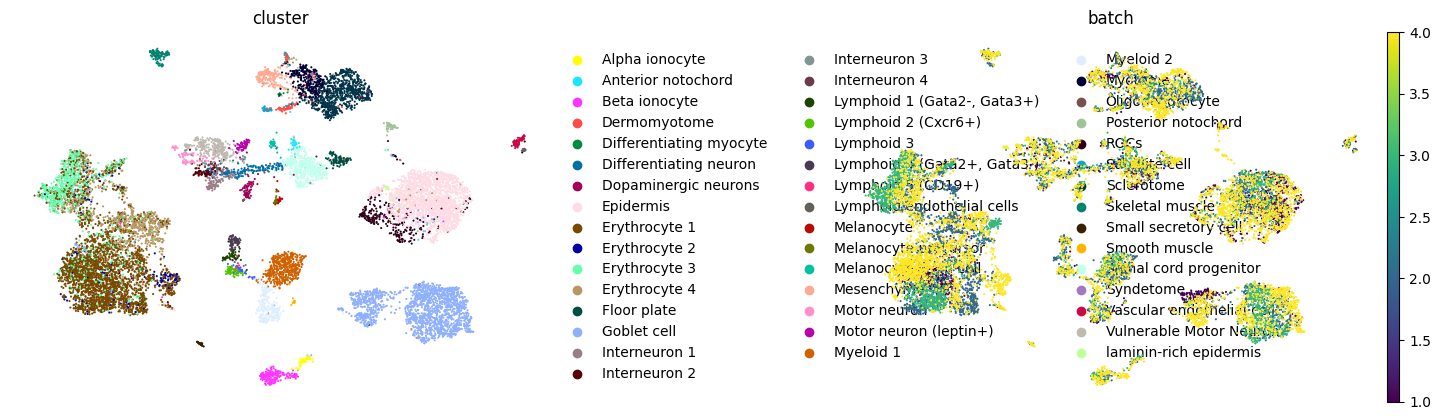

In [ ]:
sc.pp.neighbors(adata_scvi, use_rep="X_scvi", n_neighbors=15)
sc.tl.umap(adata_scvi)

sc.pl.umap(
    adata_scvi,
    color=["cluster", "batch"],
    wspace=0.4,
    frameon=False,
)

In [ ]:
import re
import numpy as np
import pandas as pd
import scanpy as sc

TABLE3_GENES = [
    "wnt5a","loc100488523","loc100492954","egfl6","lpar3","cpa6","sp9","fgf9","fbn2",
    "tinagl1","fgf7","vwde","lef1","lamb2","fgfr4","fgf7","rspo2","cpa6","loc100498358",
    "krt","loc100486832","jag1","Xelaev18043128m","dlx2","tp73","gdf6","Xelaev18046800m",
    "nid2","igfbp2","ism2","dlx2","loc100493805","frem2","Xelaev18044182m","bmp5","tspear",
    "sema3f","robo4","jchain","rspo2","adamts18","pltp","Xelaev18034799m","lamb1","lamb1",
    "unc5b","mmp28","fgf10","pzp","galnt15",
]

def canon(g):
    g = str(g).strip()
    g = re.sub(r'\.(L|S)$', '', g)
    g = re.sub(r'[^A-Za-z0-9]', '', g)
    return g.upper()

TABLE3_CANON = {canon(g) for g in TABLE3_GENES if g}

def run_roc_markers(
    adata,
    cluster_key="cluster",
    roc_label="ROCs",
    key_prefix="base",
    n_top=200,
    expression_source="raw",
):
    # ---- checks ----
    if cluster_key not in adata.obs:
        raise ValueError(f"{cluster_key} not found in adata.obs")

    # enforce categorical for safety
    if not pd.api.types.is_categorical_dtype(adata.obs[cluster_key]):
        adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")

    cats = list(adata.obs[cluster_key].cat.categories)
    if roc_label not in cats:
        raise ValueError(
            f"{roc_label} not found in {cluster_key} categories.\n"
            f"Available: {cats}"
        )

    if expression_source not in {"raw", "X"}:
        raise ValueError("expression_source must be 'raw' or 'X'")
    use_raw_flag = (expression_source == "raw")

    # ---- Wilcoxon: ROC vs rest ----
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        groups=[roc_label],
        reference="rest",
        method="wilcoxon",
        use_raw=use_raw_flag,
        key_added=f"{key_prefix}_markers_wilcoxon",
    )

    # ---- LogReg: all clusters ----
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method="logreg",
        use_raw=use_raw_flag,
        key_added=f"{key_prefix}_markers_logreg_all",
    )

    def _get_df(key, group):
        rg = adata.uns[key]
        names = rg["names"][group][:n_top]
        scores = rg["scores"][group][:n_top]

        if "pvals_adj" in rg:
            pvals = rg["pvals_adj"][group][:n_top]
        elif "pvals" in rg:
            pvals = rg["pvals"][group][:n_top]
        else:
            pvals = np.full(len(names), np.nan)

        if "logfoldchanges" in rg:
            logfc = rg["logfoldchanges"][group][:n_top]
        else:
            logfc = np.full(len(names), np.nan)

        return pd.DataFrame(
            {"gene": names, "score": scores, "logFC": logfc, "pval_adj": pvals}
        )

    w_key = f"{key_prefix}_markers_wilcoxon"
    l_key = f"{key_prefix}_markers_logreg_all"

    roc_w = _get_df(w_key, roc_label)
    roc_l = _get_df(l_key, roc_label)

    overlap = pd.merge(roc_w, roc_l, on="gene", suffixes=("_wilcoxon", "_logreg"))

    # ---- overlap with Table 3 ----
    roc_w_c = roc_w.copy(); roc_w_c["gene_c"] = roc_w_c["gene"].map(canon)
    roc_l_c = roc_l.copy(); roc_l_c["gene_c"] = roc_l_c["gene"].map(canon)
    overlap_c = overlap.copy(); overlap_c["gene_c"] = overlap_c["gene"].map(canon)

    w_in_t3 = roc_w_c[roc_w_c["gene_c"].isin(TABLE3_CANON)]
    l_in_t3 = roc_l_c[roc_l_c["gene_c"].isin(TABLE3_CANON)]
    both_in_t3 = overlap_c[overlap_c["gene_c"].isin(TABLE3_CANON)]

    print(
        f"{key_prefix} [{expression_source}]: "
        f"Wilcoxon∩Table3={len(w_in_t3)}, "
        f"LogReg∩Table3={len(l_in_t3)}, "
        f"BothMethods∩Table3={len(both_in_t3)}"
    )

    return roc_w, roc_l, overlap, w_in_t3, l_in_t3, both_in_t3


In [ ]:
import scanpy.external as sce

# start from your processed object (with HVGs, counts, etc.)
adata_harmony = adata.copy()

# --- sanity: need 'batch' and HVGs ---
if "batch" not in adata_harmony.obs.columns:
    raise ValueError("adata.obs['batch'] missing - required for Harmony.")
if "highly_variable" not in adata_harmony.var:
    raise ValueError("adata.var['highly_variable'] missing - run highly_variable_genes first.")

# make sure batch is categorical (Harmony likes this)
adata_harmony.obs["batch"] = adata_harmony.obs["batch"].astype("category")

# --- PCA on HVGs (no densifying full matrix) ---
hvg_mask = adata_harmony.var["highly_variable"].values
adata_hvg = adata_harmony[:, hvg_mask].copy()

sc.pp.scale(adata_hvg, zero_center=True, max_value=10)
sc.tl.pca(adata_hvg, n_comps=50, svd_solver="arpack")

# store PCs back
adata_harmony.obsm["X_pca"] = adata_hvg.obsm["X_pca"].copy()

# --- Harmony integration (this is the key line) ---
sce.pp.harmony_integrate(
    adata_harmony,
    key="batch",
    basis="X_pca",                # use these PCs
    adjusted_basis="X_pca_harmony"
)


2025-11-11 01:53:57,073 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-11-11 01:53:59,789 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-11-11 01:53:59,839 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-11-11 01:54:02,310 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-11-11 01:54:04,781 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-11-11 01:54:07,900 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


In [ ]:
# clustering on Harmony PCs with your helper
harmony_metrics = run_clustering(
    adata_harmony,
    prefix="harmony",
    ref_key="cluster",
    use_rep="X_pca_harmony",
)
display(harmony_metrics)

# markers still on raw or baseline expression
harmony_roc_w, harmony_roc_l, harmony_overlap, \
harmony_w_t3, harmony_l_t3, harmony_both_t3 = run_roc_markers(
    adata_harmony,
    cluster_key="cluster",
    roc_label="ROCs",
    key_prefix="harmony",
    expression_source="raw",
)


method  n_clusters  ARI_vs_ref  RandIndex_vs_ref  Silhouette  \
0  harmony_leiden          38    0.483911          0.927514    0.255459   
1  harmony_kmeans          46    0.535782          0.916502    0.325212   

   CalinskiHarabasz  DaviesBouldin  
0       1645.723018       1.153158  
1       2113.136242       1.124882

harmony [raw]: Wilcoxon∩Table3=19, LogReg∩Table3=28, BothMethods∩Table3=16


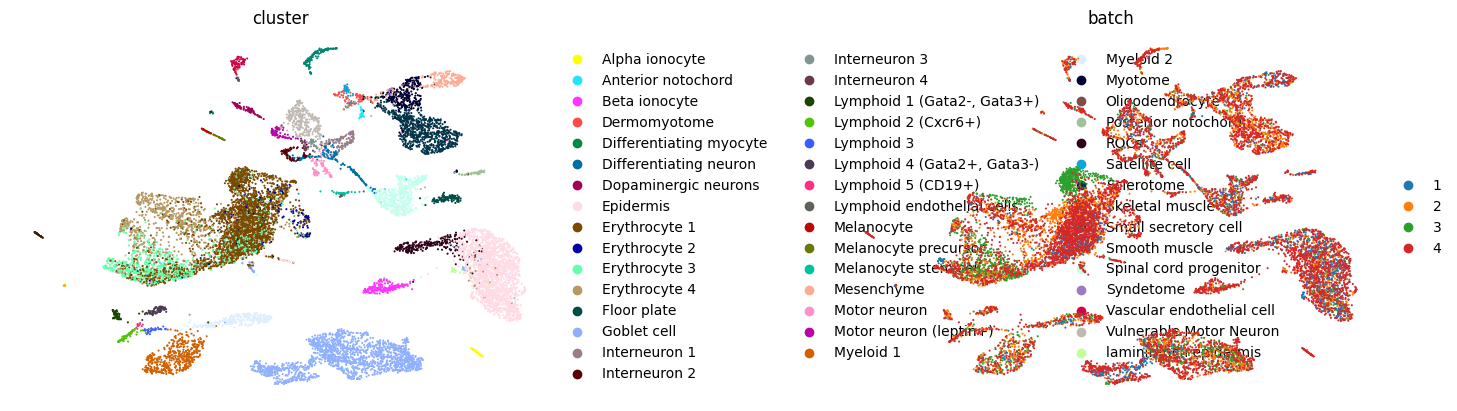

In [ ]:
# neighbors on Harmony PCs
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony", n_neighbors=15)
sc.tl.umap(adata_harmony)

sc.pl.umap(
    adata_harmony,
    color=["cluster", "batch"],
    wspace=0.4,
    frameon=False,
)


# Batch Integration

In [ ]:
import scanpy.external as sce

# --- BBKNN on PCA (batch integration) ---
adata_bbknn = adata.copy()

if "highly_variable" not in adata_bbknn.var:
    raise ValueError("Run sc.pp.highly_variable_genes on `adata` before this block.")

# PCA on HVGs only
hvg_mask = adata_bbknn.var["highly_variable"].values
adata_bbknn_hvg = adata_bbknn[:, hvg_mask].copy()
sc.pp.scale(adata_bbknn_hvg, zero_center=True, max_value=10)
sc.tl.pca(adata_bbknn_hvg, n_comps=50, svd_solver="arpack")
adata_bbknn.obsm["X_pca"] = adata_bbknn_hvg.obsm["X_pca"].copy()

# BBKNN neighbors by batch (uses X_pca)
sce.pp.bbknn(adata_bbknn, batch_key="batch")

# UMAP on BBKNN graph
sc.tl.umap(adata_bbknn)

# Leiden on BBKNN graph
sc.tl.leiden(adata_bbknn, key_added="bbknn_leiden")

# KMeans on PCA (for comparison)
if "cluster" in adata_bbknn.obs:
    n_true = int(adata_bbknn.obs["cluster"].nunique())
else:
    n_true = 20

X_pca_bb = adata_bbknn.obsm["X_pca"]
km = KMeans(n_clusters=n_true, random_state=0, n_init=10)
adata_bbknn.obs["bbknn_kmeans"] = km.fit_predict(X_pca_bb).astype(str)

# --- Metrics vs annotated clusters (using X_pca for both) ---
bb_rows = []
if "cluster" in adata_bbknn.obs:
    y_true = adata_bbknn.obs["cluster"].astype("category")

    for key in ["bbknn_leiden", "bbknn_kmeans"]:
        y_pred = adata_bbknn.obs[key].astype("category")
        n_clust = y_pred.nunique()

        if n_clust > 1:
            labs = y_pred.cat.codes.values
            ari = adjusted_rand_score(y_true, y_pred)
            ri = rand_score(y_true, y_pred)
            sil = silhouette_score(X_pca_bb, labs)
            ch = calinski_harabasz_score(X_pca_bb, labs)
            db = davies_bouldin_score(X_pca_bb, labs)
        else:
            ari = ri = sil = ch = db = np.nan

        bb_rows.append({
            "method": key,
            "n_clusters": n_clust,
            "ARI_vs_ref": ari,
            "RandIndex_vs_ref": ri,
            "Silhouette": sil,
            "CalinskiHarabasz": ch,
            "DaviesBouldin": db,
        })

bbknn_metrics = pd.DataFrame(bb_rows)
print("BBKNN clustering metrics:")
display(bbknn_metrics)

# --- ROC markers using raw expression (Table 3 comparison handled inside) ---
bbknn_roc_w, bbknn_roc_l, bbknn_overlap, bbknn_w_t3, bbknn_l_t3, bbknn_both_t3 = run_roc_markers(
    adata_bbknn,
    cluster_key="cluster",
    roc_label="ROCs",
    key_prefix="bbknn",
    expression_source="raw",
)


BBKNN clustering metrics:


method  n_clusters  ARI_vs_ref  RandIndex_vs_ref  Silhouette  \
0  bbknn_leiden          34    0.511020          0.929677    0.245883   
1  bbknn_kmeans          46    0.526036          0.914686    0.349193   

   CalinskiHarabasz  DaviesBouldin  
0       1584.144287       1.227045  
1       1972.115967       1.152038

bbknn [raw]: Wilcoxon∩Table3=19, LogReg∩Table3=28, BothMethods∩Table3=16


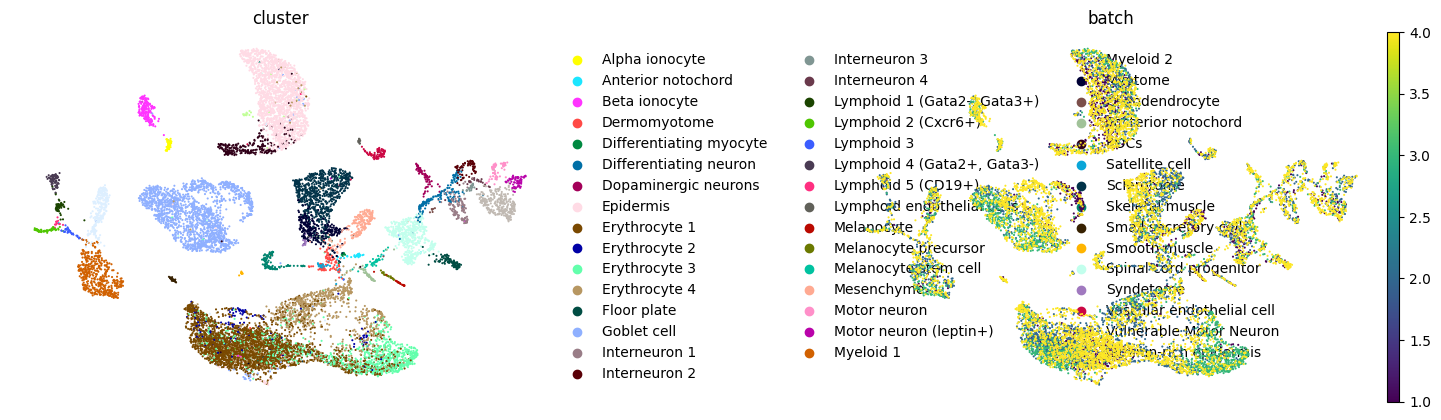

In [ ]:
sc.pl.umap(
    adata_bbknn,
    color=["cluster", "batch"],
    wspace=0.4,
    frameon=False,
)


In [ ]:
base_roc_w, base_roc_l, base_overlap, base_w_t3, base_l_t3, base_both_t3= run_roc_markers(adata,         key_prefix="base",    expression_source="raw")

def top_genes(df, n=50):
    return set(df["gene"][:n])

marker_sets = {
    "base":    top_genes(base_roc_w),
    "magic":   top_genes(magic_roc_w),
    "scvi":    top_genes(scvi_roc_w),
    "harmony": top_genes(harmony_roc_w),
    "bbknn":   top_genes(bbknn_roc_w),
}

# Overlap of each method with base
rows = []
for name, genes in marker_sets.items():
    if name == "base":
        continue
    rows.append({
        "pipeline": name,
        "overlap_with_base_top50": len(genes & marker_sets["base"]),
    })

markers_overlap_df = pd.DataFrame(rows)
display(markers_overlap_df)


base [raw]: Wilcoxon∩Table3=19, LogReg∩Table3=28, BothMethods∩Table3=16


pipeline  overlap_with_base_top50
0    magic                       15
1     scvi                       16
2  harmony                       50
3    bbknn                       50

In [ ]:
def count_table3_overlap(df, n=50):
    return sum(canon(g) in TABLE3_CANON for g in df["gene"][:n])

rows = []
rows.append({"pipeline": "base",    "top50_in_Table3": count_table3_overlap(base_roc_w)})
rows.append({"pipeline": "magic",   "top50_in_Table3": count_table3_overlap(magic_roc_w)})
rows.append({"pipeline": "scvi",    "top50_in_Table3": count_table3_overlap(scvi_roc_w)})
rows.append({"pipeline": "harmony", "top50_in_Table3": count_table3_overlap(harmony_roc_w)})
rows.append({"pipeline": "bbknn",   "top50_in_Table3": count_table3_overlap(bbknn_roc_w)})

table3_comp = pd.DataFrame(rows)
display(table3_comp)


pipeline  top50_in_Table3
0     base                5
1    magic               20
2     scvi               19
3  harmony                5
4    bbknn                5

In [ ]:
all_metrics = []

# (1) Base
base_metrics = run_clustering(adata, prefix="base", ref_key="cluster", use_rep=None)
base_metrics["pipeline"] = "base"
all_metrics.append(base_metrics)

# (2) MAGIC
magic_metrics["pipeline"] = "magic"
all_metrics.append(magic_metrics)

# (3) scVI (uses latent)
scvi_metrics["pipeline"] = "scvi"
all_metrics.append(scvi_metrics)

# (4) Harmony
harmony_metrics["pipeline"] = "harmony"
all_metrics.append(harmony_metrics)

# (5) BBKNN
# For bbknn you already computed bbknn_metrics manually; just tag it:
bbknn_metrics["pipeline"] = "bbknn"
all_metrics.append(bbknn_metrics)

metrics_all = pd.concat(all_metrics, ignore_index=True)

display(
    metrics_all[["pipeline", "method", "n_clusters",
                 "ARI_vs_ref", "Silhouette",
                 "CalinskiHarabasz", "DaviesBouldin"]]
    .sort_values(["ARI_vs_ref"], ascending=False)
)

pipeline          method  n_clusters  ARI_vs_ref  Silhouette  \
4     scvi     scvi_leiden          29    0.592881    0.141092   
7  harmony  harmony_kmeans          46    0.535782    0.325212   
9    bbknn    bbknn_kmeans          46    0.526036    0.349193   
1     base     base_kmeans          46    0.526036    0.349193   
8    bbknn    bbknn_leiden          34    0.511020    0.245883   
0     base     base_leiden          36    0.484483    0.241852   
6  harmony  harmony_leiden          38    0.483911    0.255459   
3    magic    magic_kmeans          46    0.478626    0.571742   
5     scvi     scvi_kmeans          46    0.333059    0.133442   
2    magic    magic_leiden          58    0.284729    0.297470   

   CalinskiHarabasz  DaviesBouldin  
4        567.823242       1.789734  
7       2113.136242       1.124882  
9       1972.115967       1.152038  
1       1972.115967       1.152038  
8       1584.144287       1.227045  
0       1532.947266       1.318344  
6       1645.723018       1.153158  
3       3849.712646       0.750189  
5        518.081909       1.875293  
2       2014.850708       1.156042

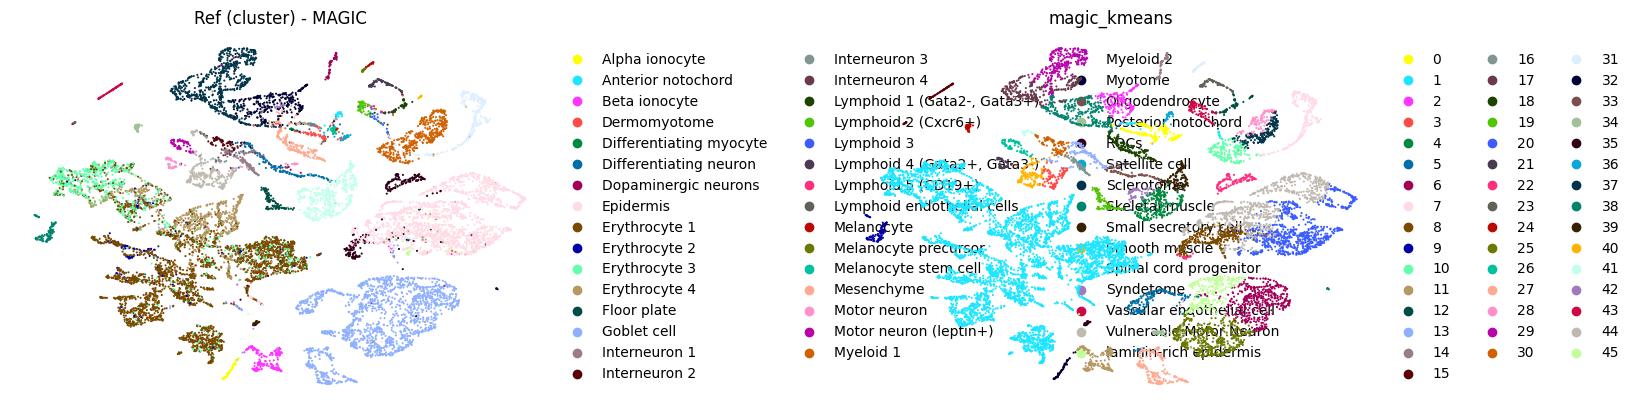

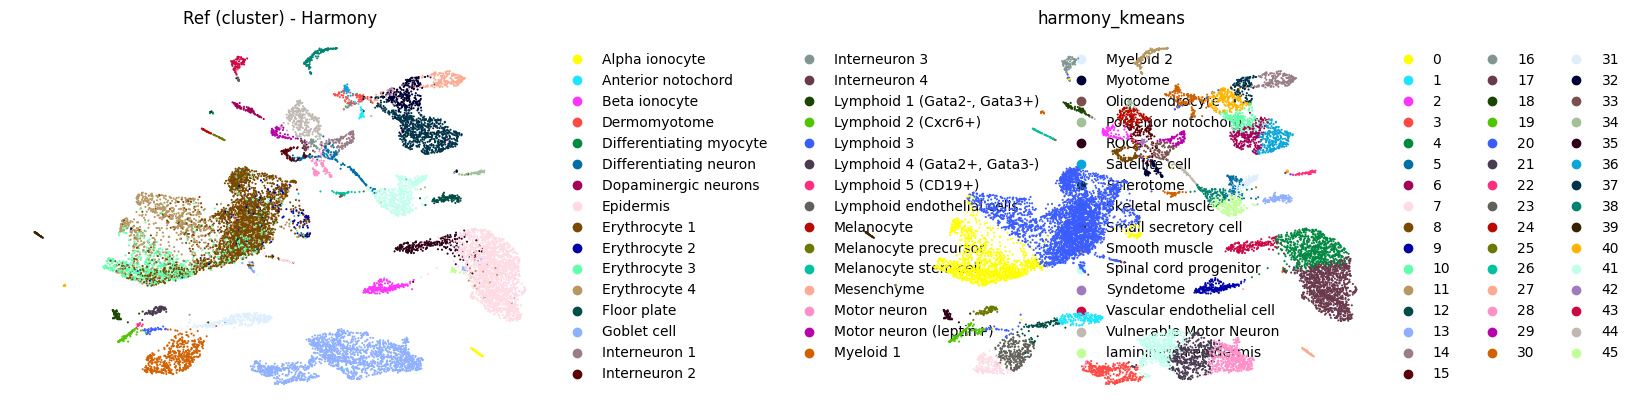

In [ ]:

# 1) MAGIC: reference vs magic_kmeans
sc.pl.umap(
    adata_magic,
    color=["cluster", "magic_kmeans"],
    ncols=2,
    frameon=False,
    wspace=0.4,
    title=["Ref (cluster) - MAGIC", "magic_kmeans"],
)

# 2) Harmony: reference vs harmony_kmeans
sc.pl.umap(
    adata_harmony,
    color=["cluster", "harmony_kmeans"],
    ncols=2,
    frameon=False,
    wspace=0.4,
    title=["Ref (cluster) - Harmony", "harmony_kmeans"],
)


In [ ]:
cluster_to_category = {
"Erythrocyte 4": "Red blood cells",
"Myeloid 1": "Immune system",
"Beta ionocyte": "Skin",
"Goblet cell": "Skin",
"Erythrocyte 1": "Red blood cells",
"Epidermis": "Skin",
"Sclerotome": "Somites",
"Myotome": "Somites",
"Spinal cord progenitor": "Neural",
"Myeloid 2": "Immune system",
"Mesenchyme": "Somites",
"ROCs": "Skin",
"Melanocyte": "Skin",
"Erythrocyte 3": "Red blood cells",
"Differentiating neuron": "Neural",
"Satellite cell": "Somites",
"Vascular endothelial cell": "Somites",
"Vulnerable Motor Neuron": "Neural",
"Alpha ionocyte": "Skin",
"Lymphoid 1 (Gata2-, Gata3+)": "Immune system",
"Lymphoid 2 (Cxcr6+)": "Immune system",
"Erythrocyte 2": "Red blood cells",
"Interneuron 1": "Neural",
"Skeletal muscle": "Somites",
"Lymphoid 4 (Gata2+, Gata3-)": "Immune system",
"Small secretory cell": "Skin",
"Floor plate": "Neural",
"Dermomyotome": "Somites",
"Interneuron 2": "Neural",
"Dopaminergic neurons": "Neural",
"Lymphoid 5 (CD19+)": "Immune system",
"Interneuron 4": "Neural",
"Melanocyte stem cell": "Skin",
"laminin-rich epidermis": "Skin",
"Motor neuron (leptin+)": "Neural",
"Motor neuron": "Neural",
"Lymphoid 3": "Immune system",
"Posterior notochord": "Somites",
"Melanocyte precursor": "Skin",
"Anterior notochord": "Somites",
"Interneuron 3": "Neural",
"Smooth muscle": "Somites",
"Syndetome": "Somites",
"Differentiating myocyte": "Somites",
"Oligodendrocyte": "Neural",
"Lymphoid endothelial cells": "Immune system"
}

adata.obs["category"] = adata.obs["cluster"].map(cluster_to_category).astype("category")



In [ ]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from scipy.io import mmread
import matplotlib.pyplot as plt

# 1. Load raw data
extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/"

X = mmread(extract_dir + "ArrayExpress/countsMatrix.mtx").tocsr()
genes = pd.read_csv(extract_dir + "ArrayExpress/genes.csv", sep=" ", header=None)
cells = pd.read_csv(extract_dir + "ArrayExpress/cells.csv", sep=" ", header=None)
labels = pd.read_csv(extract_dir + "ArrayExpress/labels.csv")
meta = pd.read_csv(extract_dir + "ArrayExpress/meta.csv")

cells.columns = ["barcode_cells"]

adata_raw = ad.AnnData(X.T)
adata_raw.var_names = genes[0]

meta_aug = pd.merge(meta, labels, left_on="sample", right_on="Sample", how="left")
adata_raw.obs = pd.merge(cells, meta_aug, left_on="barcode_cells", right_on="cell")

print("Raw AnnData:", adata_raw)

# =========================
# 2. Working object + log2 norm (paper-style)
# =========================
adata = adata_raw.copy()
adata.layers["counts"] = adata.X.copy()

# library size normalize
sc.pp.normalize_total(adata, target_sum=1e4)

# log2(x+1)
if sp.issparse(adata.X):
    Xn = adata.X.toarray()
else:
    Xn = adata.X
adata.X = np.log2(Xn + 1)

# =========================
# 3. HVGs via Fano + mean filters (paper-style)
# =========================
Xlog = adata.X
means = Xlog.mean(axis=0)
vars_ = Xlog.var(axis=0, ddof=1)

# Fano factor
fano = np.divide(vars_, means, out=np.zeros_like(vars_), where=means > 0)

thr = np.percentile(fano, 65)
hvg = fano > thr

low, high = np.percentile(means[hvg], [5, 80])
keep = hvg & (means >= low) & (means <= high)

adata = adata[:, keep].copy()

nonzero_mask = np.array((adata.X > 0).sum(axis=1)).ravel() > 0
adata = adata[nonzero_mask, :].copy()

print("After paper-style HVG & filters:", adata)

sc.pp.neighbors(
    adata,
    n_neighbors=20,
    metric="cosine",
    method="umap",
)

sc.tl.umap(
    adata,
    min_dist=0.5,
)



Raw AnnData: AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
After paper-style HVG & filters: AnnData object with n_obs × n_vars = 13199 × 8277
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
    layers: 'counts'


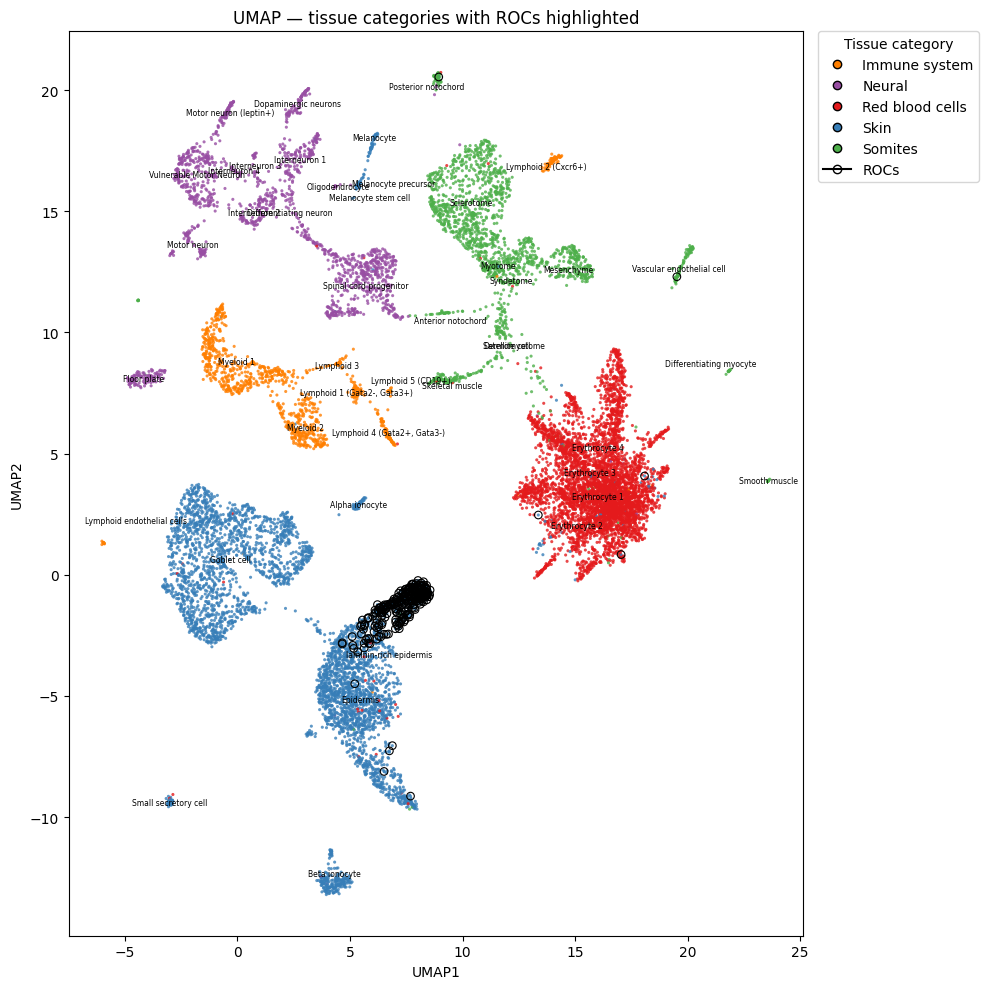

In [ ]:

from matplotlib.lines import Line2D

if "X_umap" not in adata.obsm:
    raise ValueError("adata.obsm['X_umap'] not found. Run UMAP before this cell.")

if "cluster" not in adata.obs:
    raise ValueError("adata.obs['cluster'] not found.")

if "category" not in adata.obs:
    # if missing, build from cluster_to_category
    if "cluster_to_category" in globals():
        adata.obs["category"] = (
            adata.obs["cluster"].astype(str).map(cluster_to_category)
            .fillna("Other/Unknown")
            .astype("category")
        )
    else:
        raise ValueError("adata.obs['category'] not found and cluster_to_category not defined.")

clusters = adata.obs["cluster"].astype(str)
cats = adata.obs["category"].astype(str)

coords = adata.obsm["X_umap"]

cat_colors = {
    "Red blood cells": "#e41a1c",
    "Skin": "#377eb8",
    "Somites": "#4daf4a",
    "Neural": "#984ea3",
    "Immune system": "#ff7f00",
    "Other/Unknown": "#999999",
}

unique_cats = sorted(cats.unique())
for c in unique_cats:
    if c not in cat_colors:
        cat_colors[c] = "#999999"

# map each cell to category color
point_colors = cats.map(cat_colors).to_numpy()

plt.figure(figsize=(10, 10))
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=point_colors,
    s=5,
    linewidths=0,
    alpha=0.8,
)

if "ROCs" in clusters.unique():
    roc_mask = clusters == "ROCs"
    plt.scatter(
        coords[roc_mask, 0],
        coords[roc_mask, 1],
        facecolors="none",
        edgecolors="black",
        s=30,
        linewidths=0.8,
        label="ROCs",
    )

for cl in sorted(clusters.unique()):
    mask = clusters == cl
    if mask.sum() == 0:
        continue
    x = coords[mask, 0].mean()
    y = coords[mask, 1].mean()
    plt.text(
        x,
        y,
        cl,
        fontsize=5.5,
        ha="center",
        va="center",
        color="black",
    )


# ===== legend for tissue categories (+ ROCs) =====
legend_elems = [
    Line2D(
        [0], [0],
        marker="o",
        color="none",
        markerfacecolor=cat_colors[c],
        markersize=6,
        label=c,
    )
    for c in unique_cats
]

if "ROCs" in clusters.unique():
    legend_elems.append(
        Line2D(
            [0], [0],
            marker="o",
            color="black",
            markerfacecolor="none",
            markersize=6,
            label="ROCs",
        )
    )

plt.legend(
    handles=legend_elems,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
    title="Tissue category",
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP — tissue categories with ROCs highlighted")
plt.tight_layout()
plt.show()

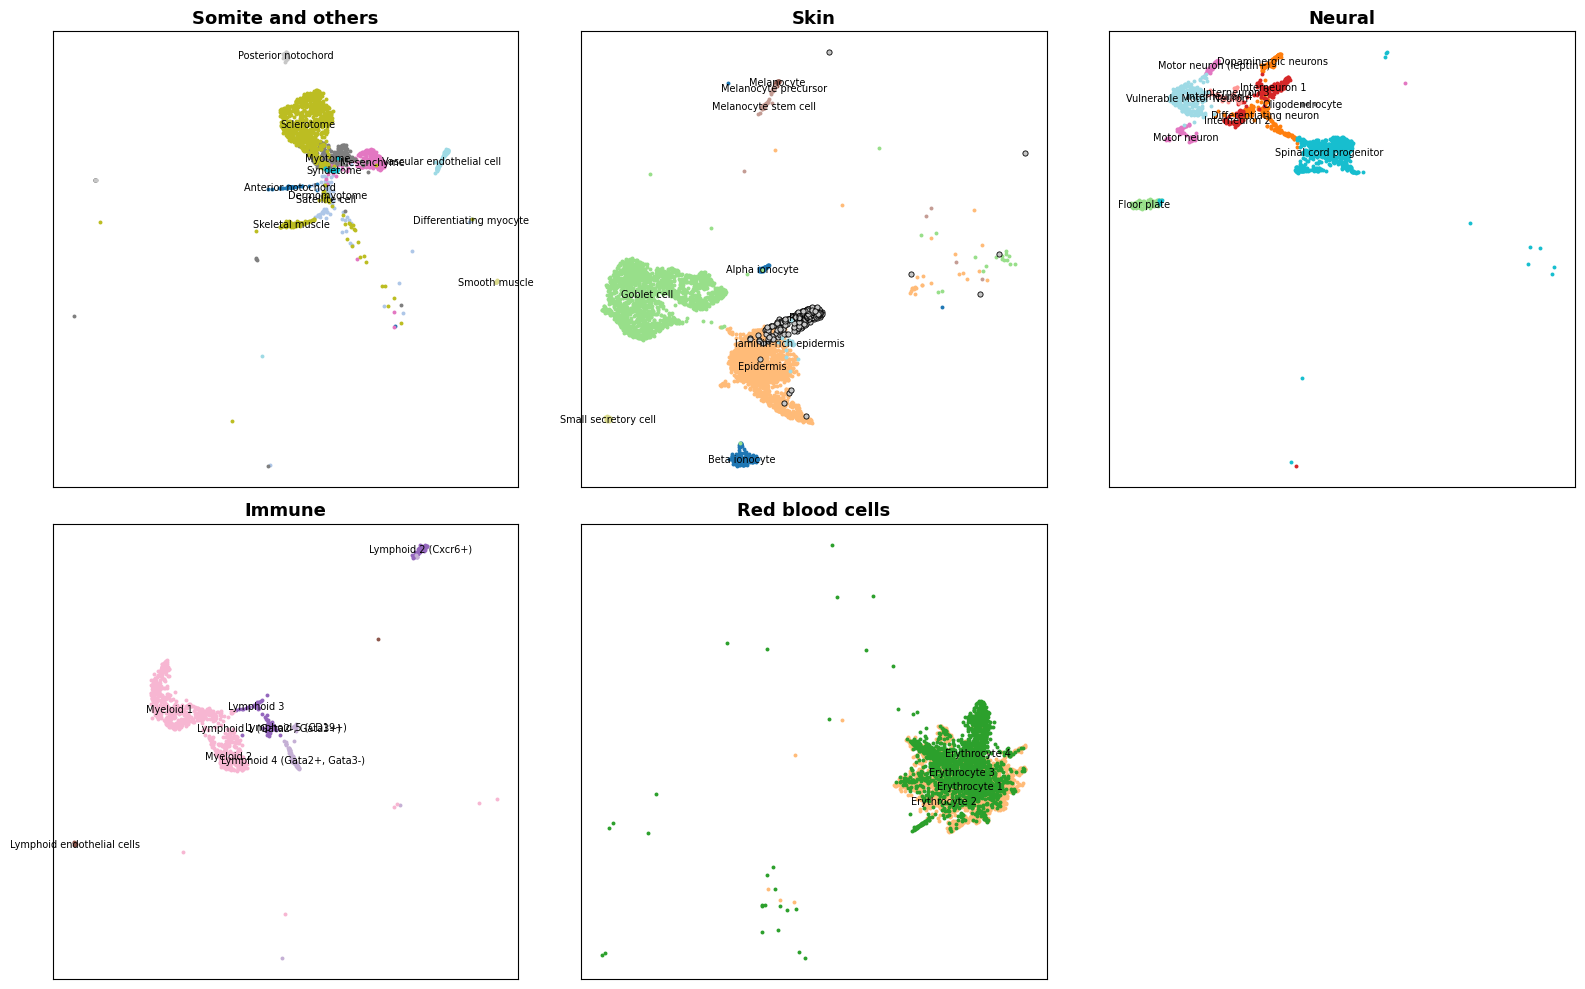

In [ ]:

X = adata.obsm["X_umap"][:, 0]
Y = adata.obsm["X_umap"][:, 1]

clusters = adata.obs["cluster"].astype("category").cat.categories

cluster_colors = {}
if "cluster_colors" in adata.uns and len(adata.uns["cluster_colors"]) == len(clusters):
    for cl, c in zip(clusters, adata.uns["cluster_colors"]):
        cluster_colors[cl] = c
else:
    cmap = plt.get_cmap("tab20")
    n = len(clusters)
    for i, cl in enumerate(clusters):
        cluster_colors[cl] = cmap(i / max(1, n - 1))

panel_order = [
    ("Somites", "Somite and others"),
    ("Skin", "Skin"),
    ("Neural", "Neural"),
    ("Immune system", "Immune"),
    ("Red blood cells", "Red blood cells"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
for ax in axes[5:]:
    ax.axis("off")

for (cat, title), ax in zip(panel_order, axes):
    # subset: only cells in this category
    mask_cat = (adata.obs["category"] == cat).to_numpy()
    if not np.any(mask_cat):
        ax.axis("off")
        continue

    # clusters present in this category
    clusters_cat = (
        adata.obs.loc[mask_cat, "cluster"]
        .astype("category")
        .cat.remove_unused_categories()
        .cat.categories
    )

    # plot each cluster in this category separately
    for cl in clusters_cat:
        m = mask_cat & (adata.obs["cluster"] == cl).to_numpy()
        if not np.any(m):
            continue

        # highlight ROC cluster with black edge
        if cl == "ROCs":
            ax.scatter(
                X[m],
                Y[m],
                s=14,
                c=cluster_colors.get(cl, "red"),
                edgecolors="black",
                linewidths=0.6,
            )
        else:
            ax.scatter(
                X[m],
                Y[m],
                s=8,
                c=cluster_colors.get(cl, "C0"),
                linewidths=0,
            )

    # text labels at median of each cluster (within this category only)
    for cl in clusters_cat:
        m = mask_cat & (adata.obs["cluster"] == cl).to_numpy()
        if not np.any(m):
            continue
        xm = np.median(X[m])
        ym = np.median(Y[m])
        ax.text(
            xm,
            ym,
            cl,
            fontsize=7,
            ha="center",
            va="center",
        )

    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)

plt.tight_layout()
plt.show()


Category counts on MAGIC:
category
Red blood cells    4737
Skin               4212
Somites            1716
Neural             1539
Immune system       995
Name: count, dtype: int64


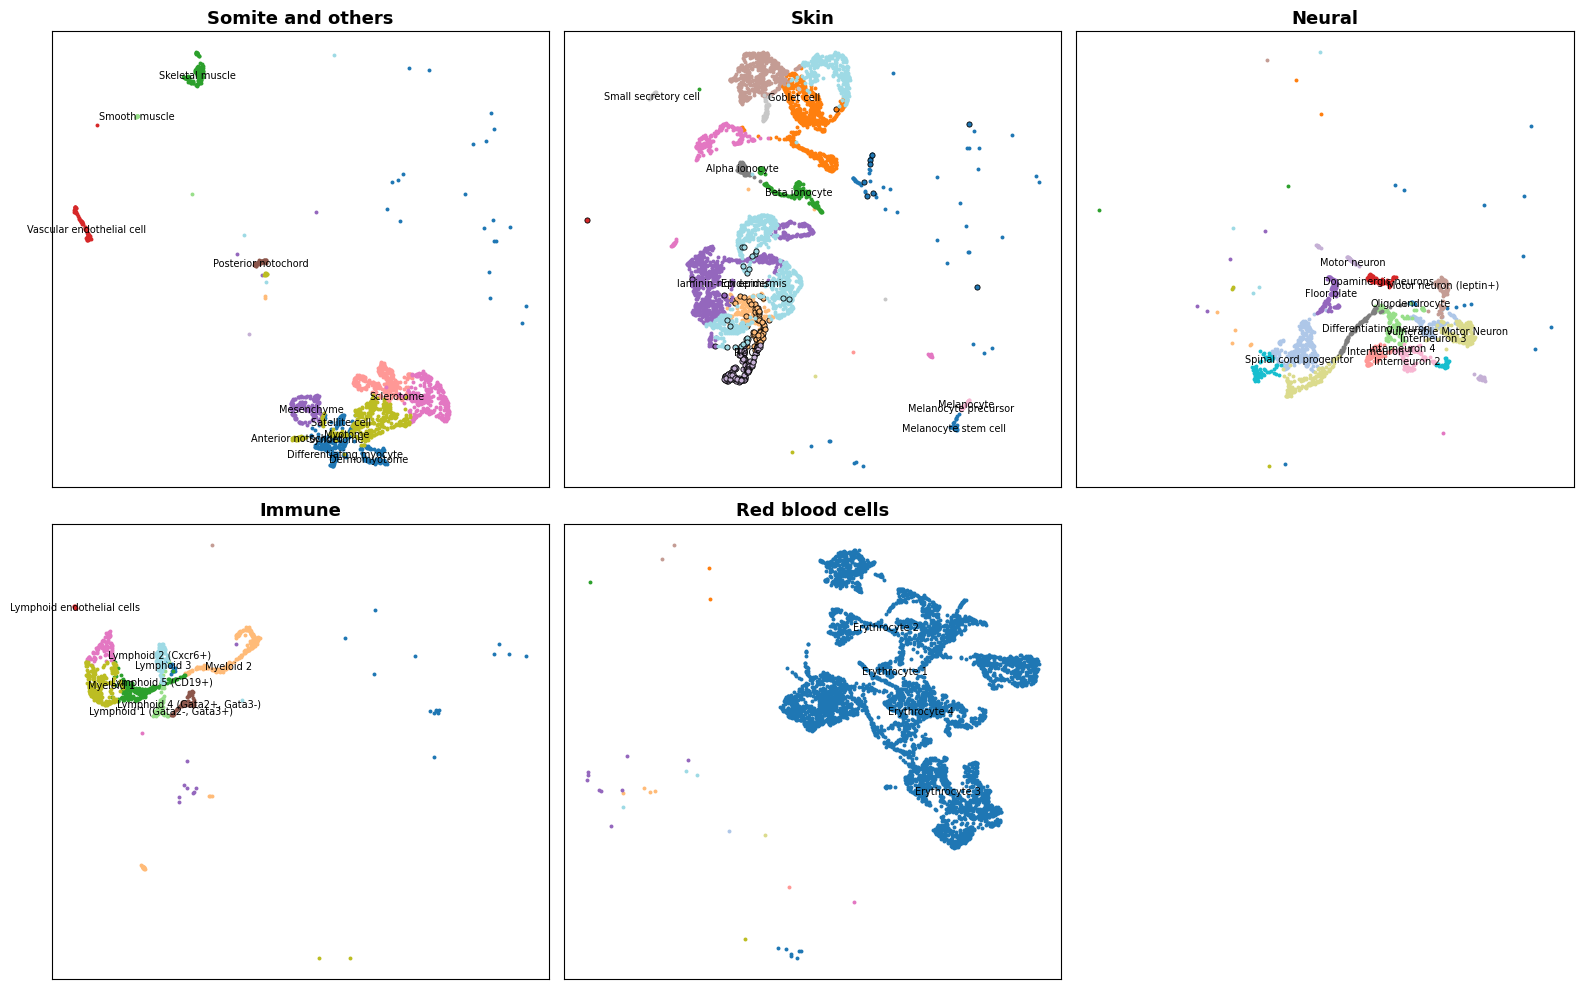

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# ------------------------------------------------
# 1. Map clusters -> tissue categories on MAGIC
# ------------------------------------------------
if "cluster" not in adata_magic.obs:
    raise ValueError("adata_magic.obs['cluster'] missing (needed for tissue categories).")

adata_magic.obs["category"] = (
    adata_magic.obs["cluster"]
    .map(cluster_to_category)
    .astype("category")
)

print("Category counts on MAGIC:")
print(adata_magic.obs["category"].value_counts())

# ------------------------------------------------
# 2. Paper-style neighbors + UMAP on MAGIC
#    (cosine, k=20, min_dist=0.5)
# ------------------------------------------------
sc.pp.neighbors(
    adata_magic,
    n_neighbors=20,
    metric="cosine",
    method="umap",
    key_added="paper20"
)

sc.tl.umap(
    adata_magic,
    min_dist=0.5,
    neighbors_key="paper20"
)

X = adata_magic.obsm["X_umap"][:, 0]
Y = adata_magic.obsm["X_umap"][:, 1]

# ------------------------------------------------
# 3. Colors for magic_kmeans clusters
# ------------------------------------------------
if "magic_kmeans" not in adata_magic.obs:
    raise ValueError("adata_magic.obs['magic_kmeans'] missing (run MAGIC clustering first).")

km_labels = adata_magic.obs["magic_kmeans"].astype("category")
km_cats = km_labels.cat.categories

cmap = plt.get_cmap("tab20")
cluster_colors = {
    cl: cmap(i / max(1, len(km_cats) - 1))
    for i, cl in enumerate(km_cats)
}

# ------------------------------------------------
# 4. Multi-panel figure by tissue category
#    Only show cells from that category in each panel
# ------------------------------------------------
panel_order = [
    ("Somites", "Somite and others"),
    ("Skin", "Skin"),
    ("Neural", "Neural"),
    ("Immune system", "Immune"),
    ("Red blood cells", "Red blood cells"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# turn off any unused axes
for ax in axes[len(panel_order):]:
    ax.axis("off")

for (cat, title), ax in zip(panel_order, axes):
    mask_cat = (adata_magic.obs["category"] == cat).to_numpy()

    if not np.any(mask_cat):
        ax.axis("off")
        continue

    # clusters present in this tissue (based on original cluster labels)
    clusters_cat = (
        adata_magic.obs.loc[mask_cat, "cluster"]
        .astype("category")
        .cat.remove_unused_categories()
        .cat.categories
    )

    # plot each magic_kmeans cluster within this category
    for km_cl in km_cats:
        m = mask_cat & (km_labels == km_cl).to_numpy()
        if not np.any(m):
            continue

        # highlight ROC *cells* (based on original annotation) with black edge
        is_roc = (adata_magic.obs["cluster"] == "ROCs").to_numpy() & m

        # non-ROC cells of this kmeans cluster
        non_roc = m & ~is_roc

        if np.any(non_roc):
            ax.scatter(
                X[non_roc],
                Y[non_roc],
                s=8,
                c=[cluster_colors[km_cl]],
                linewidths=0,
            )

        if np.any(is_roc):
            ax.scatter(
                X[is_roc],
                Y[is_roc],
                s=14,
                c=[cluster_colors[km_cl]],
                edgecolors="black",
                linewidths=0.6,
            )

    # label original named clusters at their medians (only within this tissue)
    for cl in clusters_cat:
        m_lab = mask_cat & (adata_magic.obs["cluster"] == cl).to_numpy()
        if not np.any(m_lab):
            continue
        xm = np.median(X[m_lab])
        ym = np.median(Y[m_lab])
        ax.text(
            xm,
            ym,
            cl,
            fontsize=7,
            ha="center",
            va="center",
        )

    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)

plt.tight_layout()
plt.show()


After paper-style HVG & filters: AnnData object with n_obs × n_vars = 13199 × 8277
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
    layers: 'counts'
Walktrap clustering done. #clusters: 92


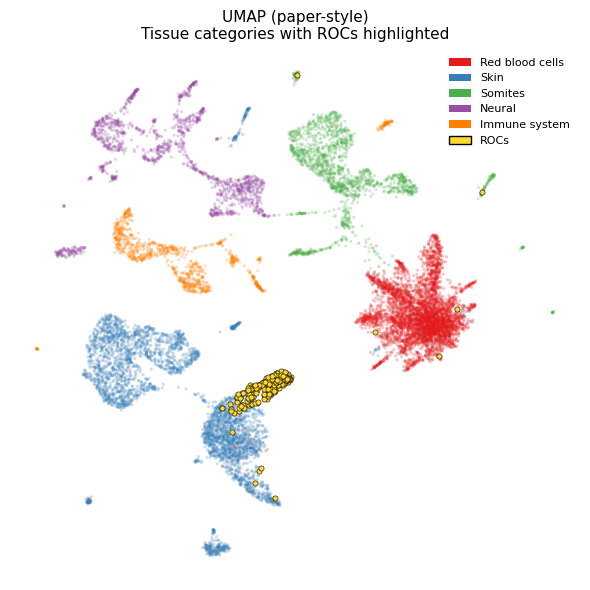

In [ ]:
import igraph as ig
import matplotlib.patches as mpatches

# ========= 1. Start from raw =========
adata = adata_raw.copy()
adata.layers["counts"] = adata.X.copy()  # keep counts for other analyses

# ========= 2. Paper-style normalization + log2 =========
sc.pp.normalize_total(adata, target_sum=1e4)

if sp.issparse(adata.X):
    adata.X = adata.X.toarray()
adata.X = np.log2(adata.X + 1)

# ========= 3. HVG selection (Fano > 65th pct; mean 5–80th pct within HVGs) =========
Xlog = adata.X
means = Xlog.mean(axis=0)
vars_ = Xlog.var(axis=0, ddof=1)

fano = np.divide(vars_, means, out=np.zeros_like(vars_), where=means > 0)

thr = np.percentile(fano, 65)
hvg_mask = fano > thr

low, high = np.percentile(means[hvg_mask], [5, 80])
keep = hvg_mask & (means >= low) & (means <= high)

adata = adata[:, keep].copy()

# drop cells with all-zero across selected HVGs
cell_nonzero = (adata.X > 0).sum(axis=1) > 0
adata = adata[cell_nonzero, :].copy()

print("After paper-style HVG & filters:", adata)

# ========= 4. Clustering graph: fuzzy_simplicial_set (k=10) + Walktrap =========
sc.pp.neighbors(
    adata,
    n_neighbors=10,
    metric="cosine",
    method="umap",
    key_added="neighbors10",
)

C = adata.obsp["neighbors10_connectivities"]
if not sp.isspmatrix_csr(C):
    C = C.tocsr()

rows, cols = C.nonzero()
weights = np.asarray(C[rows, cols]).ravel()

g = ig.Graph(
    n=C.shape[0],
    edges=list(zip(rows, cols)),
    directed=False,
)
g.es["weight"] = weights

wt = g.community_walktrap(steps=10, weights="weight").as_clustering()
adata.obs["walktrap"] = pd.Categorical(wt.membership)

print("Walktrap clustering done. #clusters:", adata.obs["walktrap"].nunique())

# ========= 5. UMAP for visualization (k=20, cosine, min_dist=0.5) =========
sc.pp.neighbors(
    adata,
    n_neighbors=20,
    metric="cosine",
    method="umap",
    key_added="neighbors20",
)

sc.tl.umap(
    adata,
    min_dist=0.5,
    neighbors_key="neighbors20",
)

# ========= 6. Categories + ROC mask =========
if "cluster" not in adata.obs:
    raise ValueError("Expected 'cluster' in adata.obs to identify ROCs.")

adata.obs["category"] = adata.obs["cluster"].map(cluster_to_category)
# leave as object, NOT categorical, to avoid fillna issues
adata.obs["category"] = adata.obs["category"].astype(object)

roc_mask = (adata.obs["cluster"] == "ROCs").values
coords = adata.obsm["X_umap"]
categories = adata.obs["category"]

# ========= 7. Single figure: tissue categories + ROC highlight =========

cat_colors = {
    "Red blood cells":  "#E41A1C",
    "Skin":             "#377EB8",
    "Somites":          "#4DAF4A",
    "Neural":           "#984EA3",
    "Immune system":    "#FF7F00",
}
default_color = "#BFBFBF"

# map each cell to a color
bg_colors = categories.map(cat_colors).fillna(default_color).values

plt.figure(figsize=(6, 6))

# background: all cells colored by category
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    s=5,
    c=bg_colors,
    linewidths=0,
    alpha=0.25,
)

# overlay: ROC cells
plt.scatter(
    coords[roc_mask, 0],
    coords[roc_mask, 1],
    s=14,
    c="#FFD92F",
    edgecolors="#000000",
    linewidths=0.4,
    alpha=0.98,
)

plt.axis("off")
plt.title("UMAP (paper-style)\nTissue categories with ROCs highlighted", fontsize=11)

# legend
handles = [
    mpatches.Patch(facecolor=color, edgecolor="none", label=cat)
    for cat, color in cat_colors.items()
]
handles.append(mpatches.Patch(facecolor="#FFD92F", edgecolor="#000000", label="ROCs"))

plt.legend(handles=handles, frameon=False, loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

In [82]:
pipelines = ["base", "magic", "scvi", "harmony", "bbknn"]
pipeline_markers = {
    "base":    (base_roc_w, base_roc_l),
    "magic":   (magic_roc_w, magic_roc_l),
    "scvi":    (scvi_roc_w, scvi_roc_l),
    "harmony": (harmony_roc_w, harmony_roc_l),
    "bbknn":   (bbknn_roc_w, bbknn_roc_l),
}

## Final Clustering Results

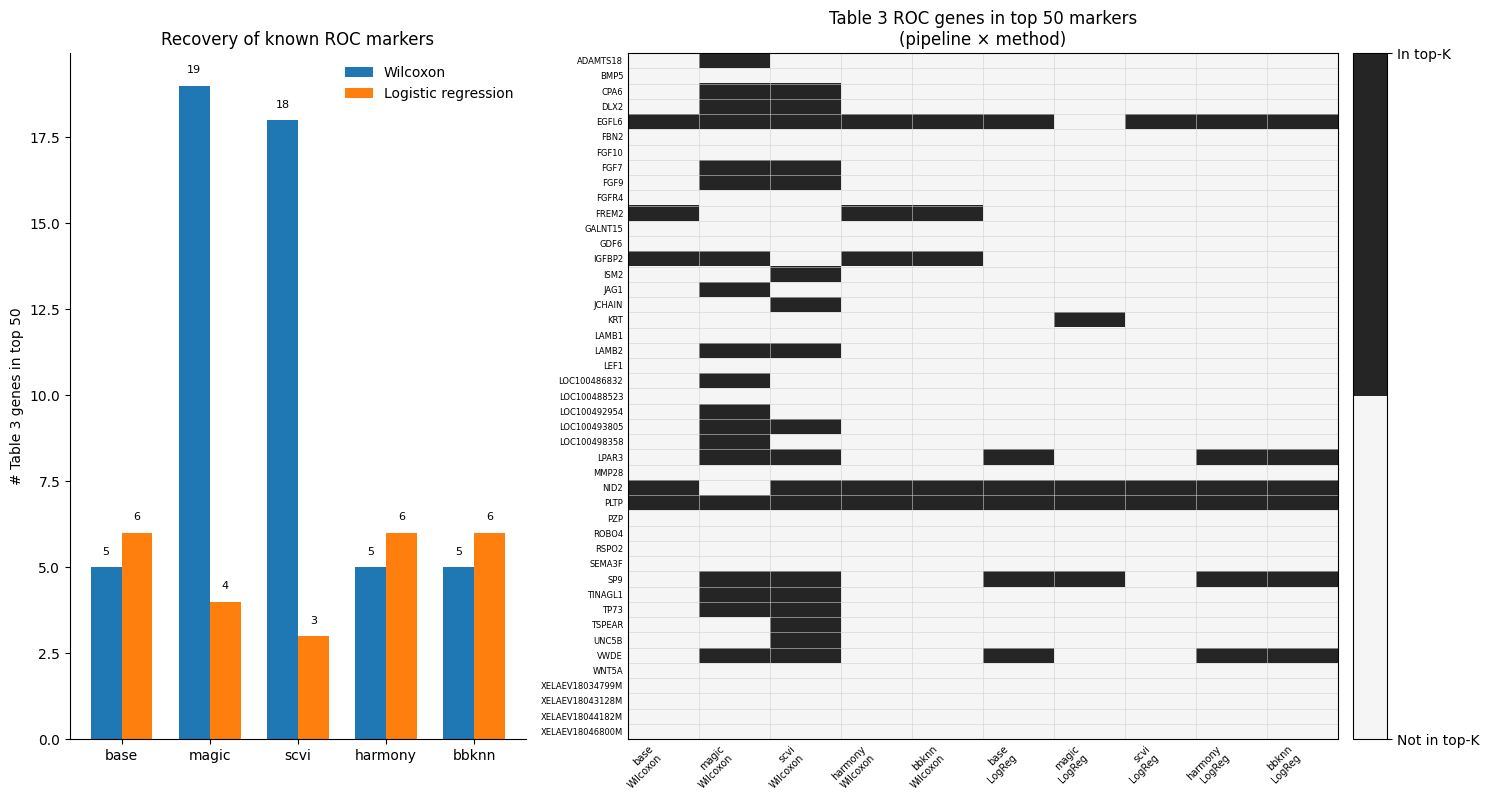

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ===== config =====
K = 50  # top-K ROC markers to check
pipelines = ["base", "magic", "scvi", "harmony", "bbknn"]

# Assumes you have:
# pipeline_markers = {
#   "base":    (base_roc_w,    base_roc_l),
#   "magic":   (magic_roc_w,   magic_roc_l),
#   "scvi":    (scvi_roc_w,    scvi_roc_l),
#   "harmony": (harmony_roc_w, harmony_roc_l),
#   "bbknn":   (bbknn_roc_w,   bbknn_roc_l),
# }

def topK_table3_hits(roc_df, K=50):
    sub = roc_df.head(K).copy()
    sub["gene_c"] = sub["gene"].map(canon)
    genes = {g for g in sub["gene_c"] if g in TABLE3_CANON}
    return len(genes), genes

# ===== collect stats =====
records = []
heatmap_members = {}  # (pipeline, method) -> set of Table3 genes (canonical) in top-K

for p in pipelines:
    roc_w, roc_l = pipeline_markers[p]

    # Wilcoxon
    w_count, w_genes = topK_table3_hits(roc_w, K)
    records.append({"pipeline": p, "method": "Wilcoxon", "hits": w_count})
    heatmap_members[(p, "Wilcoxon")] = w_genes

    # LogReg
    l_count, l_genes = topK_table3_hits(roc_l, K)
    records.append({"pipeline": p, "method": "LogReg", "hits": l_count})
    heatmap_members[(p, "LogReg")] = l_genes

bar_df = pd.DataFrame(records)

# Prepare values in consistent order
x = np.arange(len(pipelines))
width = 0.35

wilcoxon_vals = [
    bar_df[(bar_df.pipeline == p) & (bar_df.method == "Wilcoxon")]["hits"].values[0]
    for p in pipelines
]
logreg_vals = [
    bar_df[(bar_df.pipeline == p) & (bar_df.method == "LogReg")]["hits"].values[0]
    for p in pipelines
]

# ===== build binary heatmap matrix =====
t3_genes_sorted = sorted(TABLE3_CANON)
cols = [(p, "Wilcoxon") for p in pipelines] + [(p, "LogReg") for p in pipelines]

heat = np.zeros((len(t3_genes_sorted), len(cols)), dtype=int)
for j, (p, m) in enumerate(cols):
    genes_here = heatmap_members[(p, m)]
    for i, g in enumerate(t3_genes_sorted):
        if g in genes_here:
            heat[i, j] = 1

# ===== plotting: side-by-side =====
fig, (ax_bar, ax_heat) = plt.subplots(
    1, 2, figsize=(15, max(4, len(t3_genes_sorted) * 0.18)),
    gridspec_kw={"width_ratios": [1.2, 2.0]}
)

# --- Left: grouped bar chart ---
ax_bar.bar(x - width/2, wilcoxon_vals, width, label="Wilcoxon")
ax_bar.bar(x + width/2, logreg_vals, width, label="Logistic regression")

ax_bar.set_xticks(x)
ax_bar.set_xticklabels(pipelines, rotation=0)
ax_bar.set_ylabel(f"# Table 3 genes in top {K}")
ax_bar.set_title("Recovery of known ROC markers")
ax_bar.legend(frameon=False)

# Add value labels for clarity
for xi, v in zip(x - width/2, wilcoxon_vals):
    ax_bar.text(xi, v + 0.3, str(v), ha="center", va="bottom", fontsize=8)
for xi, v in zip(x + width/2, logreg_vals):
    ax_bar.text(xi, v + 0.3, str(v), ha="center", va="bottom", fontsize=8)

ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)

# --- Right: binary heatmap ---
# Discrete 0/1 colormap: light for 0, dark for 1
cmap = ListedColormap(["#f5f5f5", "#252525"])

im = ax_heat.imshow(heat, aspect="auto", interpolation="nearest",
                    cmap=cmap, vmin=0, vmax=1)

# Ticks & labels
ax_heat.set_yticks(np.arange(len(t3_genes_sorted)))
ax_heat.set_yticklabels(t3_genes_sorted, fontsize=6)
ax_heat.set_xticks(np.arange(len(cols)))
ax_heat.set_xticklabels(
    [f"{p}\n{m}" for (p, m) in cols],
    rotation=45,
    ha="right",
    fontsize=7
)

ax_heat.set_title(f"Table 3 ROC genes in top {K} markers\n(pipeline × method)")

# Add grid lines to make it clearly gridded
ax_heat.set_xticks(np.arange(-0.5, len(cols), 1), minor=True)
ax_heat.set_yticks(np.arange(-0.5, len(t3_genes_sorted), 1), minor=True)
ax_heat.grid(which="minor", color="#d0d0d0", linestyle="-", linewidth=0.4)
ax_heat.tick_params(which="both", length=0)

# Colorbar with binary label
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.02)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Not in top-K", "In top-K"])

plt.tight_layout()
plt.show()


For marker selection Wilcoxon + Logistic Regression

In [ ]:
print(adata.obs.columns)

print("\ncluster value_counts():")
print(adata.obs["cluster"].value_counts())

Index(['barcode_cells', 'cell', 'sample', 'DevelopmentalStage',
       'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample',
       'Lane', 'Condition', 'batch', 'walktrap', 'category'],
      dtype='object')

cluster value_counts():
cluster
Erythrocyte 1                  2761
Epidermis                      1800
Goblet cell                    1754
Erythrocyte 3                   982
Erythrocyte 4                   862
Sclerotome                      752
Spinal cord progenitor          505
Myeloid 1                       475
Myotome                         303
Vulnerable Motor Neuron         284
Myeloid 2                       265
ROCs                            254
Mesenchyme                      215
Beta ionocyte                   207
Differentiating neuron          158
Erythrocyte 2                   132
Interneuron 1                   128
Skeletal muscle                 117
Floor plate                     109
Dermomyotome                     84
Dopaminergic neurons 

ROC cells: 254
Total cells: 13199


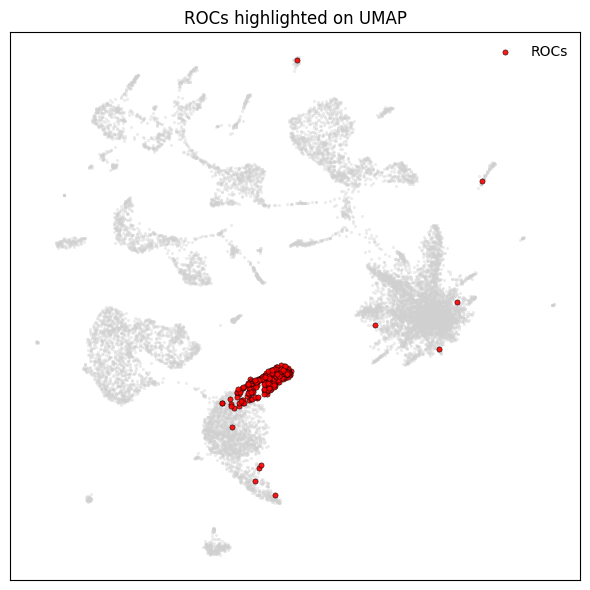

In [ ]:
import matplotlib.pyplot as plt

# Boolean mask for ROC cells
roc_mask = adata.obs["cluster"] == "ROCs"

print("ROC cells:", roc_mask.sum())
print("Total cells:", adata.n_obs)

# Needs adata.obsm["X_umap"] precomputed
coords = adata.obsm["X_umap"]

plt.figure(figsize=(6, 6))

# all cells (grey)
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    s=5,
    c="#d0d0d0",
    alpha=0.4,
    linewidths=0,
)

# ROCs (red w/ outline)
plt.scatter(
    coords[roc_mask, 0],
    coords[roc_mask, 1],
    s=14,
    c="red",
    edgecolors="black",
    linewidths=0.4,
    alpha=0.9,
    label="ROCs",
)

plt.title("ROCs highlighted on UMAP")
plt.xticks([]); plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


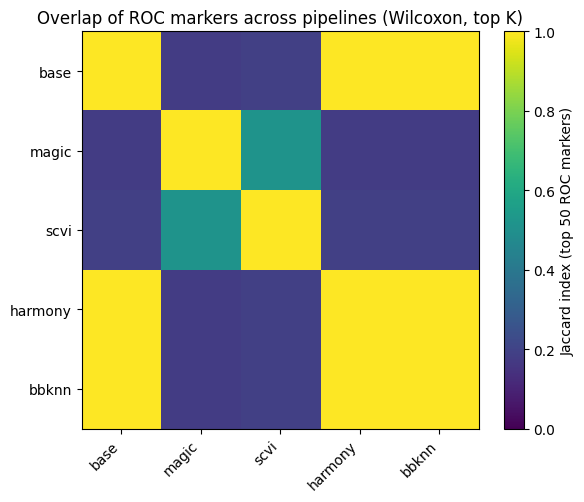

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

K = 50  # top-K markers to compare



def topK_set(df, K):
    return set(df["gene"].head(K))

# Build Jaccard similarity matrix
jac = np.zeros((len(pipelines), len(pipelines)))

for i, p1 in enumerate(pipelines):
    s1 = topK_set(pipeline_markers[p1], K)
    for j, p2 in enumerate(pipelines):
        s2 = topK_set(pipeline_markers[p2], K)
        inter = len(s1 & s2)
        union = len(s1 | s2) if len(s1 | s2) > 0 else 1
        jac[i, j] = inter / union

plt.figure(figsize=(6, 5))
im = plt.imshow(jac, vmin=0, vmax=1, interpolation="nearest")
plt.colorbar(im, label=f"Jaccard index (top {K} ROC markers)")
plt.xticks(range(len(pipelines)), pipelines, rotation=45, ha="right")
plt.yticks(range(len(pipelines)), pipelines)
plt.title("Overlap of ROC markers across pipelines (Wilcoxon, top K)")
plt.tight_layout()
plt.show()


In [89]:
K = 50

# collect top-K sets per pipeline
top_sets = {}
for p in pipelines:
    roc_w, roc_l = pipeline_markers[p]
    # Combine genes from both Wilcoxon and LogReg top-K results
    combined_genes = set(roc_w["gene"].head(K)) | set(roc_l["gene"].head(K))
    top_sets[p] = {canon(g) for g in combined_genes}

all_genes = sorted(set().union(*top_sets.values()))

rows = []
for g in all_genes:
    present_in = [p for p in pipelines if g in top_sets[p]]
    rows.append({
        "gene_canon": g,
        "n_pipelines": len(present_in),
        "pipelines": ",".join(present_in),
        "in_Table3": g in TABLE3_CANON,
    })

consensus_df = pd.DataFrame(rows)

# sort: most robust first, Table3 hits at top
consensus_df = consensus_df.sort_values(
    by=["n_pipelines", "in_Table3"],
    ascending=[False, False]
).reset_index(drop=True)

# show top 30 for the report; keep full df for analysis
consensus_df.head(50)

gene_canon  n_pipelines                      pipelines  in_Table3
0              EGFL6            5  base,magic,scvi,harmony,bbknn       True
1              LPAR3            5  base,magic,scvi,harmony,bbknn       True
2               NID2            5  base,magic,scvi,harmony,bbknn       True
3               PLTP            5  base,magic,scvi,harmony,bbknn       True
4                SP9            5  base,magic,scvi,harmony,bbknn       True
5               VWDE            5  base,magic,scvi,harmony,bbknn       True
6          APOC1LIKE            5  base,magic,scvi,harmony,bbknn      False
7              AZIN2            5  base,magic,scvi,harmony,bbknn      False
8              BAMBI            5  base,magic,scvi,harmony,bbknn      False
9               BCAM            5  base,magic,scvi,harmony,bbknn      False
10           COL14A1            5  base,magic,scvi,harmony,bbknn      False
11             EPCAM            5  base,magic,scvi,harmony,bbknn      False
12               FN1            5  base,magic,scvi,harmony,bbknn      False
13             FRAS1            5  base,magic,scvi,harmony,bbknn      False
14            FREM21            5  base,magic,scvi,harmony,bbknn      False
15               ID3            5  base,magic,scvi,harmony,bbknn      False
16             KRT12            5  base,magic,scvi,harmony,bbknn      False
17             KRT16            5  base,magic,scvi,harmony,bbknn      False
18             KRT18            5  base,magic,scvi,harmony,bbknn      False
19             KRT57            5  base,magic,scvi,harmony,bbknn      False
20              KRT8            5  base,magic,scvi,harmony,bbknn      False
21             LAMA1            5  base,magic,scvi,harmony,bbknn      False
22             LAMA5            5  base,magic,scvi,harmony,bbknn      False
23      LOC100486548            5  base,magic,scvi,harmony,bbknn      False
24      LOC100490088            5  base,magic,scvi,harmony,bbknn      False
25            LY6G6C            5  base,magic,scvi,harmony,bbknn      False
26               MDK            5  base,magic,scvi,harmony,bbknn      False
27              MMP3            5  base,magic,scvi,harmony,bbknn      False
28              OPTC            5  base,magic,scvi,harmony,bbknn      False
29              PLK2            5  base,magic,scvi,harmony,bbknn      False
30             SPARC            5  base,magic,scvi,harmony,bbknn      False
31            TMSB4X            5  base,magic,scvi,harmony,bbknn      False
32  XELAEV18017960MG            5  base,magic,scvi,harmony,bbknn      False
33  XELAEV18026267MG            5  base,magic,scvi,harmony,bbknn      False
34   XETROV90029035M            5  base,magic,scvi,harmony,bbknn      False
35            IGFBP2            4       base,magic,harmony,bbknn       True
36              BTG1            4        base,scvi,harmony,bbknn      False
37            CLDN61            4        base,scvi,harmony,bbknn      False
38            CLDN62            4       base,magic,harmony,bbknn      False
39             FSTL1            4       base,magic,harmony,bbknn      False
40               HBD            4       base,magic,harmony,bbknn      False
41      LOC100127750            4       base,magic,harmony,bbknn      False
42               LUM            4        base,scvi,harmony,bbknn      False
43              MSX2            4        base,scvi,harmony,bbknn      False
44           S100A11            4        base,scvi,harmony,bbknn      False
45  XELAEV18045083MG            4       base,magic,harmony,bbknn      False
46  XELAEV18045098MG            4       base,magic,harmony,bbknn      False
47  XELAEV18045099MG            4       base,magic,harmony,bbknn      False
48             FREM2            3             base,harmony,bbknn       True
49               APP            3             base,harmony,bbknn      False

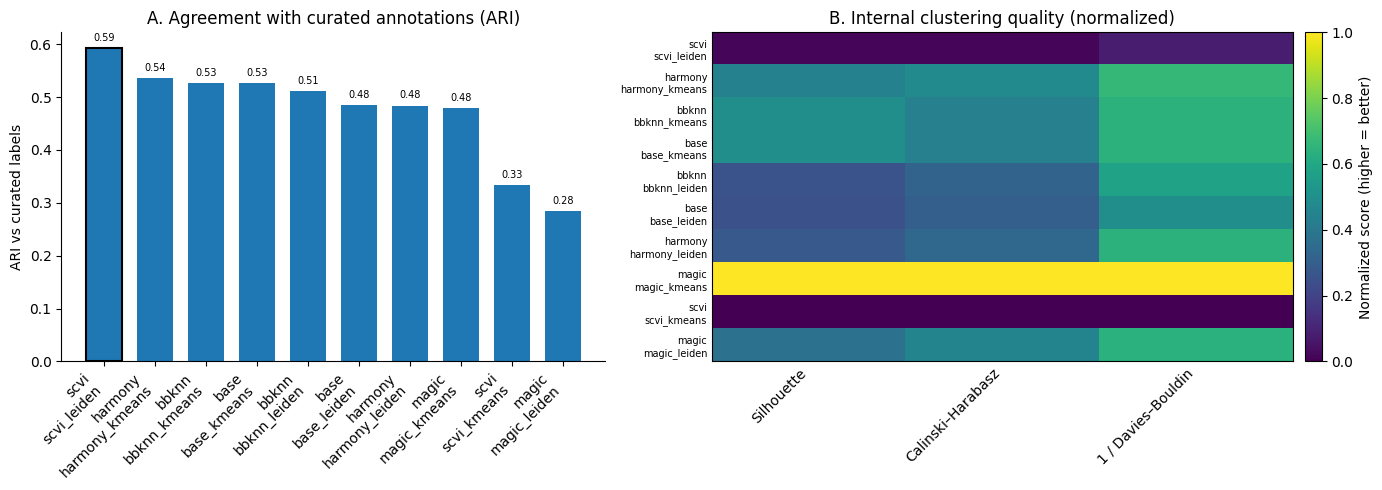

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Start from your combined metrics_all
df = metrics_all.copy()

# Build a compact label per configuration
# If your "method" is already like "base_kmeans", this will still read fine
df["label"] = df["pipeline"].astype(str) + "\n" + df["method"].astype(str)

# Sort by ARI for cleaner visualization
df = df.sort_values("ARI_vs_ref", ascending=False).reset_index(drop=True)

labels = df["label"].values
ari = df["ARI_vs_ref"].values

# Internal metrics
sil = df["Silhouette"].values
ch = df["CalinskiHarabasz"].values
db = df["DaviesBouldin"].values

def norm(v):
    vmin, vmax = np.min(v), np.max(v)
    if vmax == vmin:
        return np.ones_like(v) * 0.5  # degenerate case fallback
    return (v - vmin) / (vmax - vmin)

sil_n = norm(sil)
ch_n = norm(ch)
db_inv_n = norm(db.max() - db)  # invert DB so higher = better

metric_names = ["Silhouette", "Calinski–Harabasz", "1 / Davies–Bouldin"]
metric_matrix = np.vstack([sil_n, ch_n, db_inv_n]).T  # shape: (n_methods, 3)

# ---------- plotting ----------
fig, (ax_bar, ax_heat) = plt.subplots(
    1, 2,
    figsize=(14, 5),
    gridspec_kw={"width_ratios": [1.4, 1.6]}
)

# ===== Panel A: ARI vs curated labels =====
x = np.arange(len(labels))
bars = ax_bar.bar(x, ari, width=0.7)

# highlight best ARI
best_idx = np.argmax(ari)
bars[best_idx].set_edgecolor("black")
bars[best_idx].set_linewidth(1.5)

ax_bar.set_xticks(x)
ax_bar.set_xticklabels(labels, rotation=45, ha="right")
ax_bar.set_ylabel("ARI vs curated labels")
ax_bar.set_title("A. Agreement with curated annotations (ARI)")

ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)

# add ARI value labels
for i, v in enumerate(ari):
    ax_bar.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

# ===== Panel B: Normalized internal metrics heatmap =====
im = ax_heat.imshow(
    metric_matrix,
    aspect="auto",
    interpolation="nearest",
    cmap="viridis",
    vmin=0,
    vmax=1,
)

ax_heat.set_yticks(np.arange(len(labels)))
ax_heat.set_yticklabels(labels, fontsize=7)
ax_heat.set_xticks(np.arange(len(metric_names)))
ax_heat.set_xticklabels(metric_names, rotation=45, ha="right")

ax_heat.set_title("B. Internal clustering quality (normalized)")
ax_heat.tick_params(axis="x", length=0)
ax_heat.tick_params(axis="y", length=0)

cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.02)
cbar.set_label("Normalized score (higher = better)")

plt.tight_layout()
plt.show()


In [81]:
print(pipeline_markers)

{'base':                gene      score     logFC       pval_adj
0         col14a1.S  25.357527  5.884367  2.340832e-137
1      apoc1.like.L  25.222475  8.242413  3.580654e-136
2    loc100486548.L  25.060778  5.087452  1.400259e-134
3             mdk.L  24.477623  4.950447  2.016198e-128
4             id3.S  23.945599  4.214293  6.476695e-123
..              ...        ...       ...            ...
195          dlx5.L  13.019322  3.325606   1.498074e-36
196         aplp2.S  13.005704  1.882178   1.775344e-36
197          ier2.L  13.005588  1.732424   1.775344e-36
198        rab11a.S  13.002254  1.605552   1.845339e-36
199         lamb2.L  13.001680  5.924829   1.850121e-36

[200 rows x 4 columns], 'magic':                   gene      score     logFC       pval_adj
0              lpar3.L  26.772797  5.801023  1.753888e-153
1    Xetrov90029035m.L  26.711340  7.738851  4.546935e-153
2              lamb2.L  26.686167  5.630384  5.942070e-153
3       loc100493805.L  26.599154  6.087032  4.54

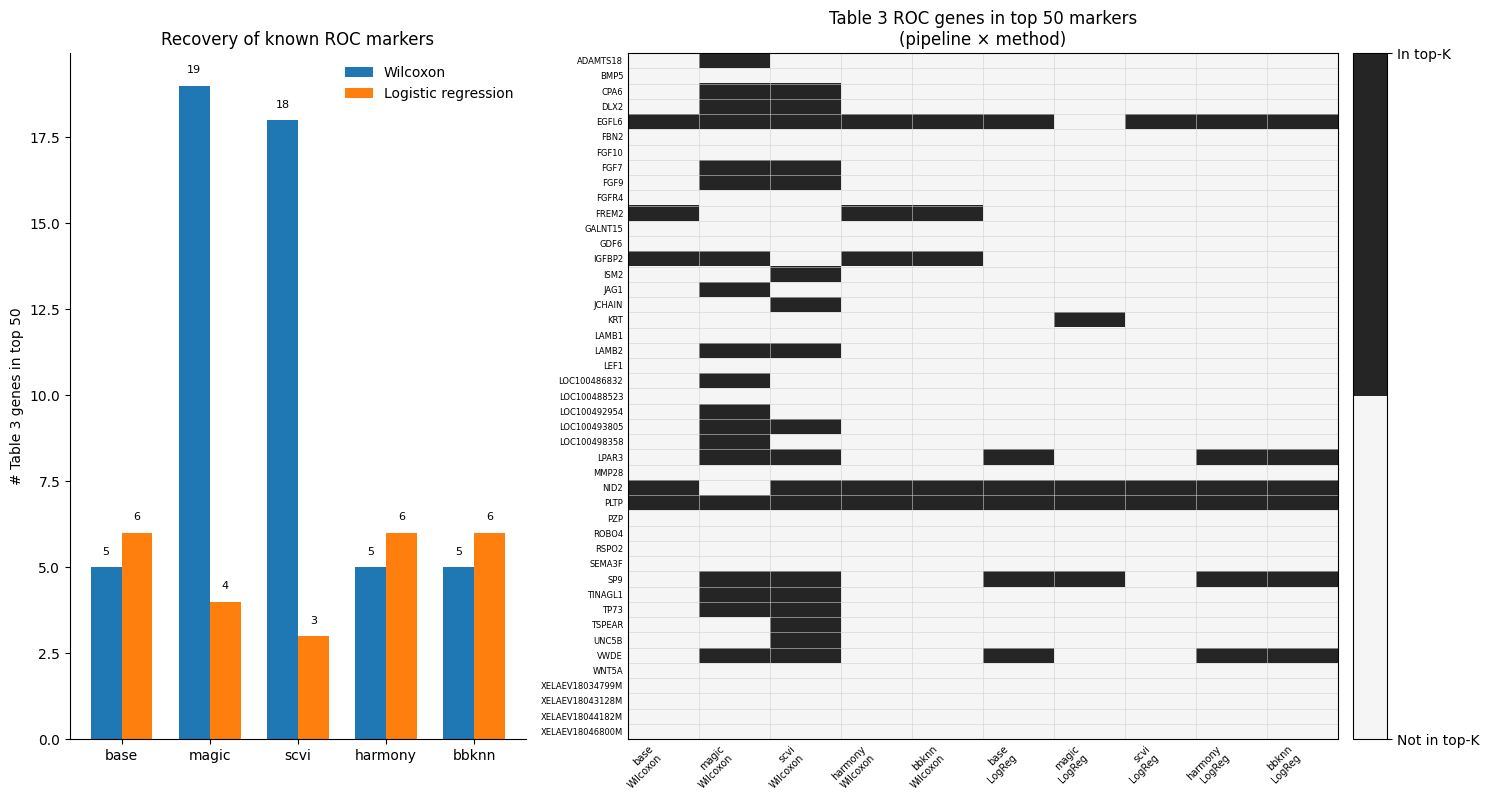

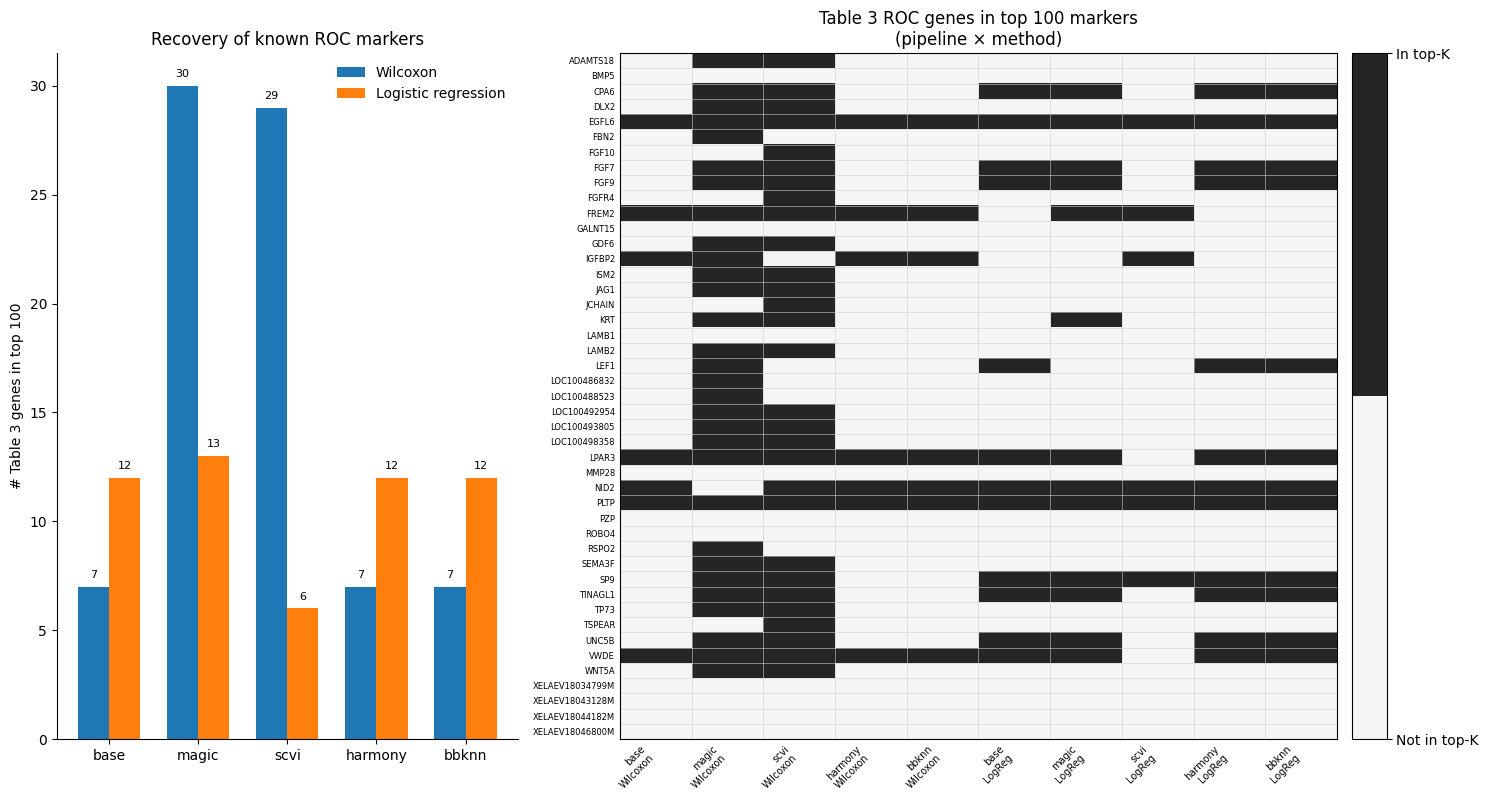

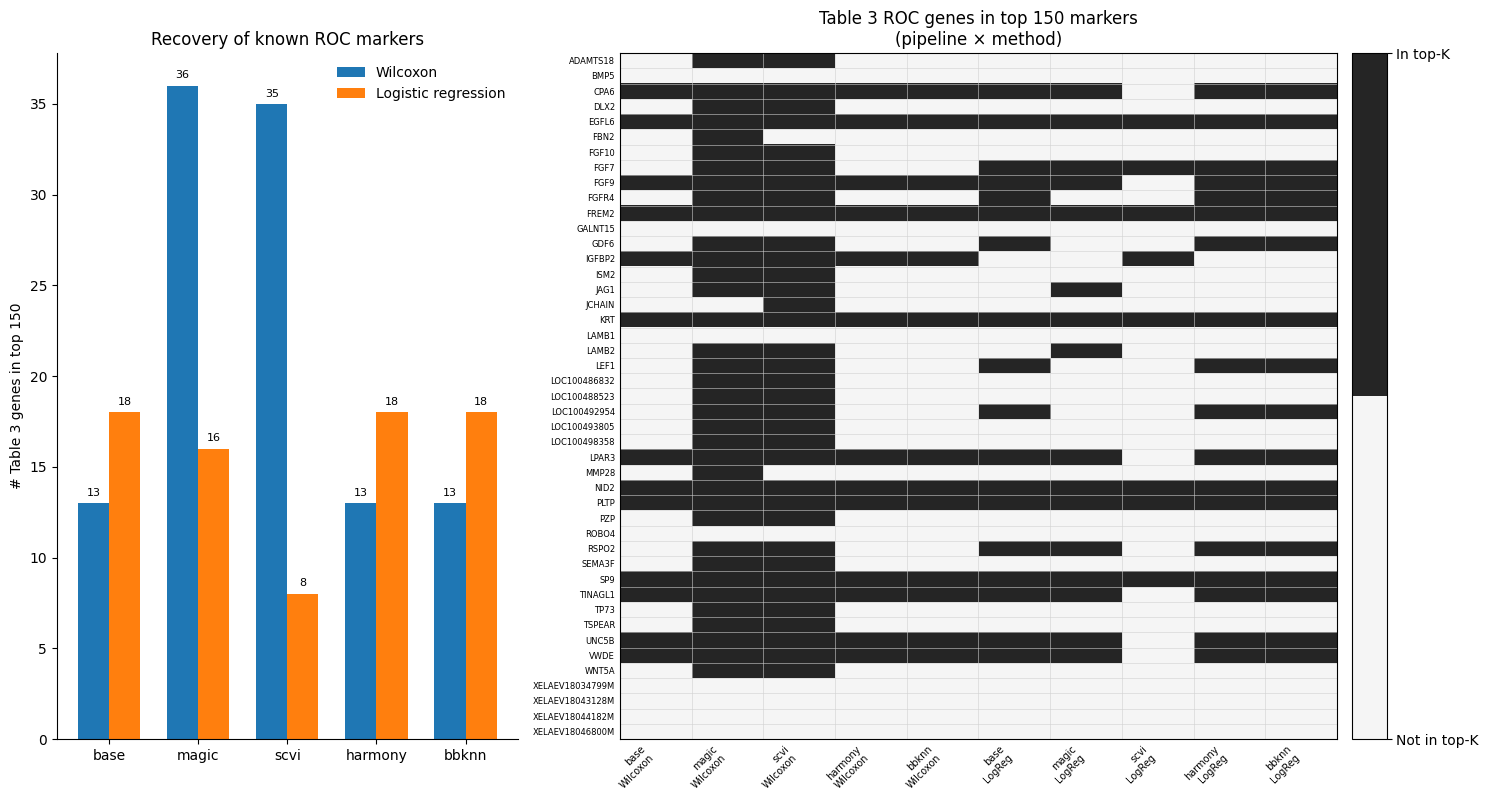

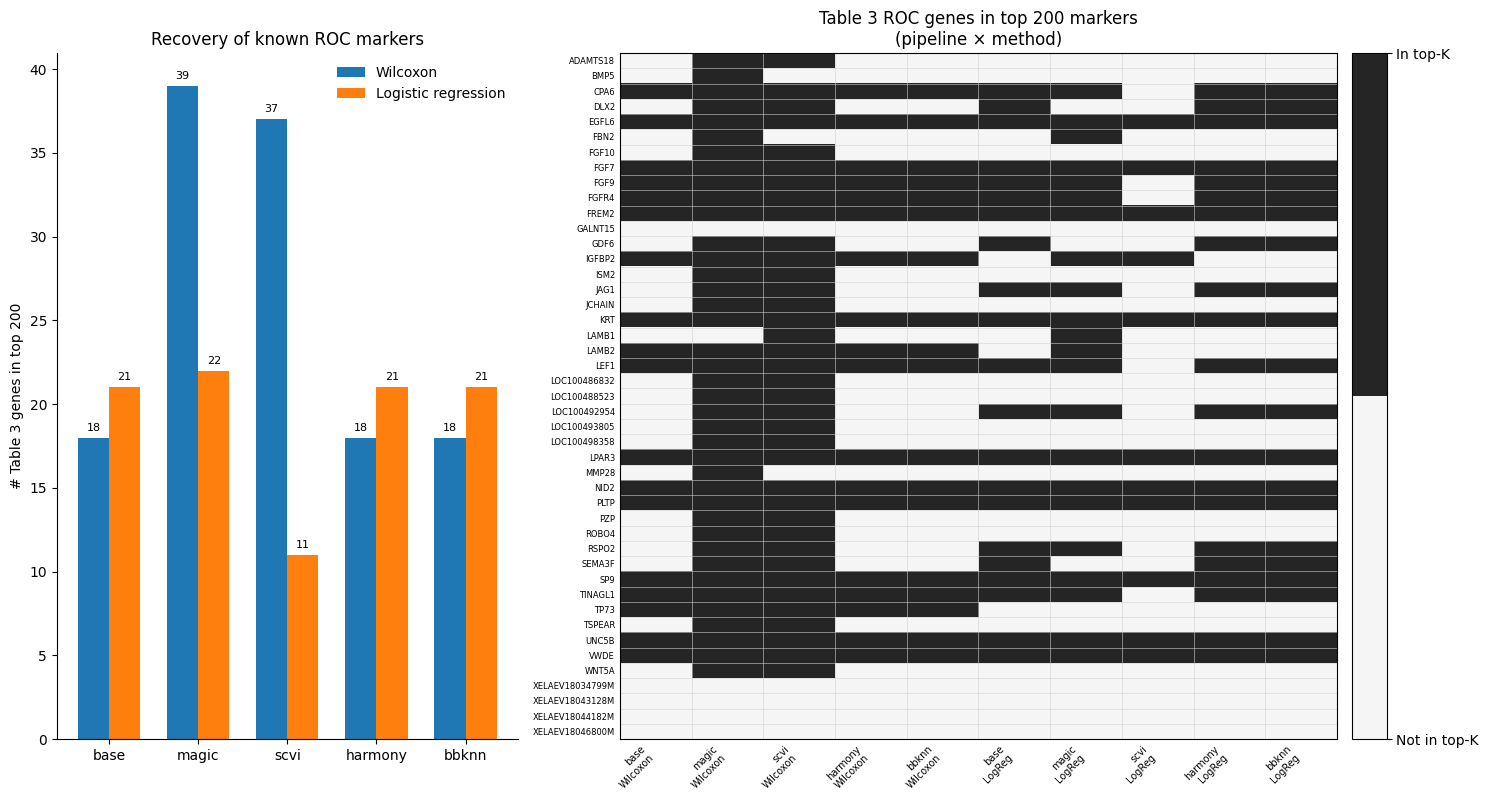

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

pipelines = ["base", "magic", "scvi", "harmony", "bbknn"]
# pipeline_markers = { "base": (base_roc_w, base_roc_l), ... }  # as before

def topK_table3_hits(roc_df, K):
    sub = roc_df.head(K).copy()
    sub["gene_c"] = sub["gene"].map(canon)
    genes = {g for g in sub["gene_c"] if g in TABLE3_CANON}
    return len(genes), genes

def plot_table3_overlap(K):
    # ---- collect stats ----
    records = []
    heatmap_members = {}

    for p in pipelines:
        roc_w, roc_l = pipeline_markers[p]

        # Wilcoxon
        w_count, w_genes = topK_table3_hits(roc_w, K)
        records.append({"pipeline": p, "method": "Wilcoxon", "hits": w_count})
        heatmap_members[(p, "Wilcoxon")] = w_genes

        # LogReg
        l_count, l_genes = topK_table3_hits(roc_l, K)
        records.append({"pipeline": p, "method": "LogReg", "hits": l_count})
        heatmap_members[(p, "LogReg")] = l_genes

    bar_df = pd.DataFrame(records)

    # bar values
    x = np.arange(len(pipelines))
    width = 0.35
    wilcoxon_vals = [
        bar_df[(bar_df.pipeline == p) & (bar_df.method == "Wilcoxon")]["hits"].iloc[0]
        for p in pipelines
    ]
    logreg_vals = [
        bar_df[(bar_df.pipeline == p) & (bar_df.method == "LogReg")]["hits"].iloc[0]
        for p in pipelines
    ]

    # ---- binary heatmap matrix ----
    t3_genes_sorted = sorted(TABLE3_CANON)
    cols = [(p, "Wilcoxon") for p in pipelines] + [(p, "LogReg") for p in pipelines]

    heat = np.zeros((len(t3_genes_sorted), len(cols)), dtype=int)
    for j, (p, m) in enumerate(cols):
        genes_here = heatmap_members[(p, m)]
        for i, g in enumerate(t3_genes_sorted):
            if g in genes_here:
                heat[i, j] = 1

    # ---- plotting ----
    fig, (ax_bar, ax_heat) = plt.subplots(
        1, 2,
        figsize=(15, max(4, len(t3_genes_sorted) * 0.18)),
        gridspec_kw={"width_ratios": [1.2, 2.0]}
    )

    # Left: grouped bar chart
    ax_bar.bar(x - width/2, wilcoxon_vals, width, label="Wilcoxon")
    ax_bar.bar(x + width/2, logreg_vals, width, label="Logistic regression")

    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(pipelines)
    ax_bar.set_ylabel(f"# Table 3 genes in top {K}")
    ax_bar.set_title("Recovery of known ROC markers")
    ax_bar.legend(frameon=False)

    for xi, v in zip(x - width/2, wilcoxon_vals):
        ax_bar.text(xi, v + 0.3, str(v), ha="center", va="bottom", fontsize=8)
    for xi, v in zip(x + width/2, logreg_vals):
        ax_bar.text(xi, v + 0.3, str(v), ha="center", va="bottom", fontsize=8)

    ax_bar.spines["top"].set_visible(False)
    ax_bar.spines["right"].set_visible(False)

    # Right: binary heatmap
    cmap = ListedColormap(["#f5f5f5", "#252525"])
    im = ax_heat.imshow(heat, aspect="auto", interpolation="nearest",
                        cmap=cmap, vmin=0, vmax=1)

    ax_heat.set_yticks(np.arange(len(t3_genes_sorted)))
    ax_heat.set_yticklabels(t3_genes_sorted, fontsize=6)
    ax_heat.set_xticks(np.arange(len(cols)))
    ax_heat.set_xticklabels(
        [f"{p}\n{m}" for (p, m) in cols],
        rotation=45, ha="right", fontsize=7
    )

    ax_heat.set_title(
        f"Table 3 ROC genes in top {K} markers\n(pipeline × method)"
    )

    ax_heat.set_xticks(np.arange(-0.5, len(cols), 1), minor=True)
    ax_heat.set_yticks(np.arange(-0.5, len(t3_genes_sorted), 1), minor=True)
    ax_heat.grid(which="minor", color="#d0d0d0", linestyle="-", linewidth=0.4)
    ax_heat.tick_params(which="both", length=0)

    cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.02)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Not in top-K", "In top-K"])

    plt.tight_layout()
    plt.show()

# ----- run for multiple K -----
for K in [50, 100, 150, 200]:
    plot_table3_overlap(K)


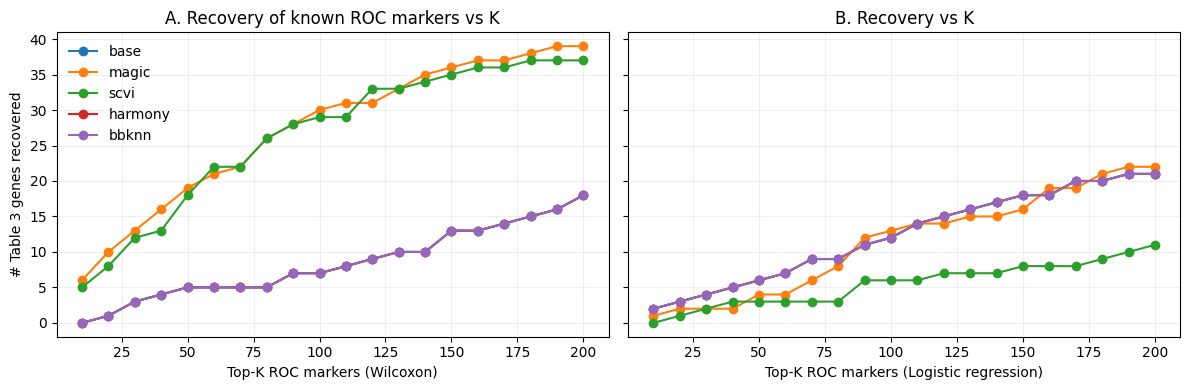

In [84]:
import numpy as np
import matplotlib.pyplot as plt

pipelines = ["base", "magic", "scvi", "harmony", "bbknn"]
# pipeline_markers[p] = (roc_w, roc_l)

# choose K range (tweak as you like)
Ks = np.arange(10, 201, 10)  # 10,20,...,200

def hits_curve(roc_df, Ks):
    # precompute canonical genes in order
    genes_c = roc_df["gene"].map(canon).tolist()
    hits = []
    for K in Ks:
        sub = genes_c[:K]
        hits.append(len({g for g in sub if g in TABLE3_CANON}))
    return hits

# ---------- plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ---- left: Wilcoxon ----
ax = axes[0]
for p in pipelines:
    roc_w, _ = pipeline_markers[p]
    ax.plot(Ks, hits_curve(roc_w, Ks), marker="o", label=p)

ax.set_xlabel("Top-K ROC markers (Wilcoxon)")
ax.set_ylabel("# Table 3 genes recovered")
ax.set_title("A. Recovery of known ROC markers vs K")
ax.legend(frameon=False)
ax.grid(alpha=0.2)

# ---- right: Logistic regression ----
ax = axes[1]
for p in pipelines:
    _, roc_l = pipeline_markers[p]
    ax.plot(Ks, hits_curve(roc_l, Ks), marker="o", label=p)

ax.set_xlabel("Top-K ROC markers (Logistic regression)")
ax.set_title("B. Recovery vs K")

ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()
